<a href="https://colab.research.google.com/github/carloshernangarrido/vibration-control/blob/master/2dof_str_v6_uniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [421]:
%reset -f

from typing import List, Union
import copy

# file handling
import os
import pickle
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/TRABAJO/46_cm_inerter/TRABAJO/'

# For simulation
import sympy as sm
import numpy as np # provides basic array types and some linear algebra
import matplotlib.pyplot as plt # used for plots

# For transfer function and state space representations
import scipy as sp
import scipy.signal as sg
eps = 1e-6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Flags

In [422]:
optimize_anal = False
optimize_anal_num = False
run_benchmark = False
run_multiobj_optimization = False

# System definition

## Structural Equation Of Motion

In [423]:
# mass, stiffness and damping
m1, c1, k1, m2, c12, k12, t = sm.symbols('m1, c1, k1, m2, c12, k12, t')
# inertance
b1, b12 = sm.symbols('b1, b12')

# mass, stiffness and damping matrices
M_s = sm.Matrix([[m1 + b1 + b12, -b12],
                 [-b12,           m2 + b12]])

K_s = sm.Matrix([[k1 + k12, -k12],
                 [-k12,      k12]])

C_s = sm.Matrix([[c1 + c12, -c12],
                 [-c12,      c12]])

# Seismic excitation matrix
B_s = sm.Matrix([[m1],
                 [m2]])

In [424]:
print("M_s =", sm.latex(M_s.subs({b1: 0})))
sm.simplify(M_s)

M_s = \left[\begin{matrix}b_{12} + m_{1} & - b_{12}\\- b_{12} & b_{12} + m_{2}\end{matrix}\right]


Matrix([
[b1 + b12 + m1,     -b12],
[         -b12, b12 + m2]])

In [425]:
print("K_s =", sm.latex(K_s))
sm.simplify(K_s)

K_s = \left[\begin{matrix}k_{1} + k_{12} & - k_{12}\\- k_{12} & k_{12}\end{matrix}\right]


Matrix([
[k1 + k12, -k12],
[    -k12,  k12]])

In [426]:
print("C_s =", sm.latex(C_s))
sm.simplify(C_s)

C_s = \left[\begin{matrix}c_{1} + c_{12} & - c_{12}\\- c_{12} & c_{12}\end{matrix}\right]


Matrix([
[c1 + c12, -c12],
[    -c12,  c12]])

## State space representation

In [427]:
# State space
# System matrix
A = sm.Matrix([[sm.zeros(2,2), sm.eye(2)], 
               [-M_s.inv()*K_s,    -M_s.inv()*C_s]])
# Seismic Input Matrix
B = sm.Matrix([[sm.zeros(2,1)],
               [-M_s.inv()*B_s]])
# Story drift Output Matrix
C = sm.Matrix([[1,  0, 0, 0],
               [-1, 1, 0, 0]])
# Direct Transfer Matrix
D = sm.Matrix([[0],
               [0]])

In [428]:
sm.simplify(A)

Matrix([
[                                                                           0,                                                         0,                                                                            1,                                                         0],
[                                                                           0,                                                         0,                                                                            0,                                                         1],
[(b12*k12 - (b12 + m2)*(k1 + k12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         k12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), (b12*c12 - (b12 + m2)*(c1 + c12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         c12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[       (b1*k12 - b12*k1 + k12*m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), -k12*(b1 + m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),        (b1*c12 - b12*c1 +

In [429]:
sm.simplify(B)

Matrix([
[                                                                        0],
[                                                                        0],
[     -(b12*m2 + m1*(b12 + m2))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[-(b12*m1 + m2*(b1 + b12 + m1))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)]])

In [430]:
sm.simplify(C)

Matrix([
[ 1, 0, 0, 0],
[-1, 1, 0, 0]])

In [431]:
sm.simplify(D)

Matrix([
[0],
[0]])

## Frequency domain

### Classes

In [432]:
class Parameters:
  def __init__(self, base_parameters):
    self.base_parameters = base_parameters
  
  def get_parameters(self, alpha=None, b12_add=0, c12_add=0, k12_add=0):
    parameters = self.base_parameters.copy()
    if alpha is not None:
      parameters['c1'] = alpha*parameters['k1']
      parameters['c12'] = alpha*parameters['k12']
    parameters['b12'] += b12_add
    parameters['c12'] += c12_add
    parameters['k12'] += k12_add
    return parameters
    
class TF:
  def __init__(self, A, B, C, D, 
               w = np.linspace(0, 10, 10000)):
    self.w = w
    self.A = A
    self.B = B
    self.C = C
    self.D = D

  def subs(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.i_output = i_output
    self.parameters = parameters
    self.A_num = np.array(self.A.subs(parameters), dtype=float)
    self.B_num = np.array(self.B.subs(parameters), dtype=float)
    self.C_num = np.array(self.C.subs(parameters), dtype=float)
    self.D_num = np.array(self.D.subs(parameters), dtype=float)
    self._num, self.den = sg.ss2tf(self.A_num, self.B_num, 
                                  self.C_num[i_output], self.D_num[i_output])
    for i, coef in enumerate(self._num[0]):
      if abs(coef) > eps:
        break
    self.num = self._num[0, i:]              
    self._tf = sg.lti(self.num, self.den)
    self._freqresp_w, self._freqresp_H = self._tf.freqresp(w=self.w)
    return self
    
  def H_inf(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.subs(i_output, parameters)
    return np.linalg.norm(self._freqresp_H, ord=np.inf)

  def H_2(self, i_output=None, parameters=None):
    i_output = self.i_output if i_output is None else i_output
    parameters = self.parameters if parameters is None else parameters
    self.subs(i_output, parameters)
    return np.linalg.norm(self._freqresp_H, ord=2)

  def natural_w(self, parameters, damped=True):
    parameters = self.parameters if parameters is None else parameters
    self.subs(0, parameters)
    if damped is True:
      return np.sort(np.array(list(set(np.abs(np.imag(np.linalg.eigvals(self.A_num)))))))
    else:
      return np.sort(np.array(list(set(np.abs(np.linalg.eigvals(self.A_num))))))



# Analytical study

## Frequency domain

In [433]:
# Analytical Transfer function
s = sm.Symbol('s')
tf_anal = C*sm.Matrix.inv(s*sm.Matrix.eye(4, 4) - A)*B + D

# undamped original structure and first floor elastic only
tf_anal_b1c1zero = sm.simplify(tf_anal.subs({b1: 0, c1: 0}))
tf_anal_b1c1zero[0]


-(b12*m1*s**2 + b12*m2*s**2 + c12*m1*s + c12*m2*s + k12*m1 + k12*m2 + m1*m2*s**2)/(b12*k1*s**2 + b12*m1*s**4 + b12*m2*s**4 + c12*k1*s + c12*m1*s**3 + c12*m2*s**3 + k1*k12 + k1*m2*s**2 + k12*m1*s**2 + k12*m2*s**2 + m1*m2*s**4)

In [434]:
# Harmonic excitation
omega = sm.Symbol('omega', rational=True)
tf_anal_b1c1zero_omega = sm.simplify(tf_anal_b1c1zero.subs({s: sm.I*omega}))
print(sm.latex(sm.collect(tf_anal_b1c1zero_omega[0], omega)))
sm.collect(tf_anal_b1c1zero_omega[0], omega)

\frac{k_{12} m_{1} + k_{12} m_{2} + \omega^{2} \left(- b_{12} m_{1} - b_{12} m_{2} - m_{1} m_{2}\right) + \omega \left(i c_{12} m_{1} + i c_{12} m_{2}\right)}{- i c_{12} k_{1} \omega - k_{1} k_{12} + \omega^{4} \left(- b_{12} m_{1} - b_{12} m_{2} - m_{1} m_{2}\right) + \omega^{3} \left(i c_{12} m_{1} + i c_{12} m_{2}\right) + \omega^{2} \left(b_{12} k_{1} + k_{1} m_{2} + k_{12} m_{1} + k_{12} m_{2}\right)}


(k12*m1 + k12*m2 + omega**2*(-b12*m1 - b12*m2 - m1*m2) + omega*(I*c12*m1 + I*c12*m2))/(-I*c12*k1*omega - k1*k12 + omega**4*(-b12*m1 - b12*m2 - m1*m2) + omega**3*(I*c12*m1 + I*c12*m2) + omega**2*(b12*k1 + k1*m2 + k12*m1 + k12*m2))

In [435]:
print(sm.latex(sm.collect(tf_anal_b1c1zero_omega[1], omega)))
sm.collect(tf_anal_b1c1zero_omega[0], omega)

\frac{k_{1} m_{2}}{- i c_{12} k_{1} \omega - k_{1} k_{12} + \omega^{4} \left(- b_{12} m_{1} - b_{12} m_{2} - m_{1} m_{2}\right) + \omega^{3} \left(i c_{12} m_{1} + i c_{12} m_{2}\right) + \omega^{2} \left(b_{12} k_{1} + k_{1} m_{2} + k_{12} m_{1} + k_{12} m_{2}\right)}


(k12*m1 + k12*m2 + omega**2*(-b12*m1 - b12*m2 - m1*m2) + omega*(I*c12*m1 + I*c12*m2))/(-I*c12*k1*omega - k1*k12 + omega**4*(-b12*m1 - b12*m2 - m1*m2) + omega**3*(I*c12*m1 + I*c12*m2) + omega**2*(b12*k1 + k1*m2 + k12*m1 + k12*m2))

##  Dimensional analysis

In [436]:
# Matrix dimensional analysis
#                    M    L   T
dim_mat = np.array([[0, 1-1,  2], # H
                    [1, 1-1, -2], # k1
                    [1, 1-1, -2], # k12
                    [1,   0,  0], # m1
                    [1,   0,  0], # m2
                    [1,   0,  0], # b12
                    [1, 1-1,1-2], # c12
                    [0,   0, -1]] # omega
                   ).T
print(dim_mat)
print('rank of dim_mat = ', np.linalg.matrix_rank(dim_mat))
print('nullity of dim_mat = ', dim_mat.shape[1] - np.linalg.matrix_rank(dim_mat))


[[ 0  1  1  1  1  1  1  0]
 [ 0  0  0  0  0  0  0  0]
 [ 2 -2 -2  0  0  0 -1 -1]]
rank of dim_mat =  2
nullity of dim_mat =  6


In [437]:
omega0 = sm.Symbol('omega0', real=True, positive=True)
zeta = sm.Symbol('zeta', real=True, positive=True)
mu = sm.Symbol('mu', real=True, positive=True)
beta = sm.Symbol('beta', real=True, positive=True)
alpha_k = sm.Symbol('alpha_k', real=True, positive=True)
mu_m = sm.Symbol('mu_m', real=True, positive=True)
normalization_dict = {b12: m1*mu, 
                      k1: m1*omega0**2, 
                      c12: 2*m2*omega0*zeta, 
                      k12: sm.solve(alpha_k**2 - (k12/m2) / (omega0**2), k12)[0],  
                      m2: sm.solve(mu_m - (m2/m1), m2)[0],
                      omega: omega0*beta}
tf_anal_b1c1zero_omega_norm = tf_anal_b1c1zero_omega.subs(normalization_dict)
tf_anal_b1c1zero_omega_norm = sm.factor(tf_anal_b1c1zero_omega_norm[0], 
                                        m1, k1)
tf_anal_b1c1zero_omega_norm = sm.collect(tf_anal_b1c1zero_omega_norm, beta)
tf_anal_b1c1zero_omega_norm = sm.collect(tf_anal_b1c1zero_omega_norm, mu_m)
tf_anal_b1c1zero_omega_norm = sm.collect(tf_anal_b1c1zero_omega_norm, 2*sm.I*mu_m*zeta)

print(sm.latex(tf_anal_b1c1zero_omega_norm))
tf_anal_b1c1zero_omega_norm

\frac{\alpha_{k}^{2} \mu_{m}^{2} + \alpha_{k}^{2} \mu_{m} + \beta^{2} \left(- \mu + \mu_{m} \left(- \mu - 1\right)\right) + 2 i \beta \mu_{m} \zeta \left(\mu_{m} + 1\right)}{\omega_{0}^{2} \left(\beta^{4} \left(- \mu + \mu_{m} \left(- \mu - 1\right)\right) + 2 i \beta^{3} \mu_{m} \zeta \left(\mu_{m} + 1\right) + \beta^{2} \left(\alpha_{k}^{2} \mu_{m}^{2} + \mu + \mu_{m} \left(\alpha_{k}^{2} + 1\right)\right) + \mu_{m} \left(- \alpha_{k}^{2} - 2 i \beta \zeta\right)\right)}


(alpha_k**2*mu_m**2 + alpha_k**2*mu_m + beta**2*(-mu + mu_m*(-mu - 1)) + 2*I*beta*mu_m*zeta*(mu_m + 1))/(omega0**2*(beta**4*(-mu + mu_m*(-mu - 1)) + 2*I*beta**3*mu_m*zeta*(mu_m + 1) + beta**2*(alpha_k**2*mu_m**2 + mu + mu_m*(alpha_k**2 + 1)) + mu_m*(-alpha_k**2 - 2*I*beta*zeta)))

In [438]:
tf_anal_b1c1zero_omega_norm12 = tf_anal_b1c1zero_omega.subs(normalization_dict)
tf_anal_b1c1zero_omega_norm12 = sm.factor(tf_anal_b1c1zero_omega_norm12[1], 
                                          m1, k1)
tf_anal_b1c1zero_omega_norm12 = sm.collect(tf_anal_b1c1zero_omega_norm12, beta)
tf_anal_b1c1zero_omega_norm12 = sm.collect(tf_anal_b1c1zero_omega_norm12, mu_m)
print(sm.latex(tf_anal_b1c1zero_omega_norm12))
tf_anal_b1c1zero_omega_norm12

\frac{\mu_{m}}{\omega_{0}^{2} \left(\beta^{4} \left(- \mu + \mu_{m} \left(- \mu - 1\right)\right) + \beta^{3} \left(2 i \mu_{m}^{2} \zeta + 2 i \mu_{m} \zeta\right) + \beta^{2} \left(\alpha_{k}^{2} \mu_{m}^{2} + \mu + \mu_{m} \left(\alpha_{k}^{2} + 1\right)\right) + \mu_{m} \left(- \alpha_{k}^{2} - 2 i \beta \zeta\right)\right)}


mu_m/(omega0**2*(beta**4*(-mu + mu_m*(-mu - 1)) + beta**3*(2*I*mu_m**2*zeta + 2*I*mu_m*zeta) + beta**2*(alpha_k**2*mu_m**2 + mu + mu_m*(alpha_k**2 + 1)) + mu_m*(-alpha_k**2 - 2*I*beta*zeta)))

## Undamped natural frequencies

In [439]:
tf_num, tf_den = sm.fraction(tf_anal_b1c1zero_omega_norm)
tf_den

omega0**2*(beta**4*(-mu + mu_m*(-mu - 1)) + 2*I*beta**3*mu_m*zeta*(mu_m + 1) + beta**2*(alpha_k**2*mu_m**2 + mu + mu_m*(alpha_k**2 + 1)) + mu_m*(-alpha_k**2 - 2*I*beta*zeta))

In [440]:
tf_den_real = sm.re(tf_den)
tf_den_real = tf_den_real
tf_den_real

omega0**2*(-alpha_k**2*mu_m + beta**4*(-mu + mu_m*(-mu - 1)) + beta**2*(alpha_k**2*mu_m**2 + mu + mu_m*(alpha_k**2 + 1)))

In [441]:
beta_sol = sm.solve(tf_den_real, beta)
(beta_sol[0]/omega0**2)**2

(alpha_k**2*mu_m**2 + alpha_k**2*mu_m + mu + mu_m - sqrt(alpha_k**4*mu_m**4 + 2*alpha_k**4*mu_m**3 + alpha_k**4*mu_m**2 - 2*alpha_k**2*mu*mu_m**2 - 2*alpha_k**2*mu*mu_m + 2*alpha_k**2*mu_m**3 - 2*alpha_k**2*mu_m**2 + mu**2 + 2*mu*mu_m + mu_m**2))/(omega0**4*(2*mu*mu_m + 2*mu + 2*mu_m))

### Minimimum difference between undamped natural frequencies

In [442]:
beta_sol_quotient = beta_sol[1]/beta_sol[0]
beta_sol_quotient

sqrt(alpha_k**2*mu_m**2 + alpha_k**2*mu_m + mu + mu_m + sqrt(alpha_k**4*mu_m**4 + 2*alpha_k**4*mu_m**3 + alpha_k**4*mu_m**2 - 2*alpha_k**2*mu*mu_m**2 - 2*alpha_k**2*mu*mu_m + 2*alpha_k**2*mu_m**3 - 2*alpha_k**2*mu_m**2 + mu**2 + 2*mu*mu_m + mu_m**2))/sqrt(alpha_k**2*mu_m**2 + alpha_k**2*mu_m + mu + mu_m - sqrt(alpha_k**4*mu_m**4 + 2*alpha_k**4*mu_m**3 + alpha_k**4*mu_m**2 - 2*alpha_k**2*mu*mu_m**2 - 2*alpha_k**2*mu*mu_m + 2*alpha_k**2*mu_m**3 - 2*alpha_k**2*mu_m**2 + mu**2 + 2*mu*mu_m + mu_m**2))

In [443]:
# Optimizing mu
solu_mu = sm.solve(sm.diff(beta_sol_quotient, mu), mu)
print(sm.latex(solu_mu[0]))
print("if mu_m: 1, alpha_k: 1: ", float(solu_mu[0].subs({mu_m: 1, alpha_k: 1})))
solu_mu[0]

\frac{\alpha_{k}^{2} \mu_{m}^{3} + 2 \alpha_{k}^{2} \mu_{m}^{2} + \alpha_{k}^{2} \mu_{m} + \mu_{m}^{2} - \mu_{m}}{\mu_{m} + 1}
if mu_m: 1, alpha_k: 1:  2.0


(alpha_k**2*mu_m**3 + 2*alpha_k**2*mu_m**2 + alpha_k**2*mu_m + mu_m**2 - mu_m)/(mu_m + 1)

In [444]:
beta_sol_quotient_muopt = sm.simplify(beta_sol_quotient.subs({mu: solu_mu[0]})).subs({mu_m: 1, alpha_k: 1})
print(float(beta_sol_quotient_muopt))
sm.simplify(beta_sol_quotient_muopt)

1.618033988749895


sqrt(sqrt(5) + 5)/sqrt(5 - sqrt(5))

In [445]:
# Optimizing alpha_k
solu_alpha_k = sm.solve(sm.diff(beta_sol_quotient, alpha_k), alpha_k)
print(sm.latex(solu_alpha_k[0]))
print("if mu_m = 1, mu = 0, alpha_k ** 2 =", float(solu_alpha_k[0].subs({mu_m: 1, mu: 0})))
sm.Eq(solu_alpha_k[0]**2, alpha_k**2)

\frac{\sqrt{\mu + \mu_{m}}}{\sqrt{\mu_{m}^{2} + \mu_{m}}}
if mu_m = 1, mu = 0, alpha_k ** 2 = 0.7071067811865476


Eq((mu + mu_m)/(mu_m**2 + mu_m), alpha_k**2)

In [446]:
beta_sol_quotient_alphakopt = sm.simplify(beta_sol_quotient.subs({alpha_k: solu_alpha_k[0]})).subs({mu_m: 1, mu: 0})
print(float(beta_sol_quotient_alphakopt))
sm.simplify(beta_sol_quotient_alphakopt)

2.414213562373095


sqrt(sqrt(2) + 2)/sqrt(2 - sqrt(2))

In [447]:
# Optimization of mu_m
D_beta_sol_quotient_D_mu_m = sm.simplify(sm.diff(
    beta_sol_quotient, mu_m)).subs({alpha_k: 1, mu: 0})
D_beta_sol_quotient_D_mu_m_num, D_beta_sol_quotient_D_mu_m_den = \
  sm.fraction(D_beta_sol_quotient_D_mu_m)[0], sm.fraction(D_beta_sol_quotient_D_mu_m)[1]
print(sm.latex(D_beta_sol_quotient_D_mu_m_num))
D_beta_sol_quotient_D_mu_m_num

- 4 \mu_{m}^{3}


-4*mu_m**3

In [448]:
print(sm.latex(D_beta_sol_quotient_D_mu_m_den))
D_beta_sol_quotient_D_mu_m_den

\sqrt{\mu_{m}^{2} + 2 \mu_{m} - \sqrt{\mu_{m}^{4} + 4 \mu_{m}^{3}}} \sqrt{\mu_{m}^{2} + 2 \mu_{m} + \sqrt{\mu_{m}^{4} + 4 \mu_{m}^{3}}} \left(\mu_{m}^{4} + 4 \mu_{m}^{3} - \mu_{m}^{2} \sqrt{\mu_{m}^{4} + 4 \mu_{m}^{3}} - 2 \mu_{m} \sqrt{\mu_{m}^{4} + 4 \mu_{m}^{3}}\right)


sqrt(mu_m**2 + 2*mu_m - sqrt(mu_m**4 + 4*mu_m**3))*sqrt(mu_m**2 + 2*mu_m + sqrt(mu_m**4 + 4*mu_m**3))*(mu_m**4 + 4*mu_m**3 - mu_m**2*sqrt(mu_m**4 + 4*mu_m**3) - 2*mu_m*sqrt(mu_m**4 + 4*mu_m**3))

## Fixed points

### $||H_1(i \omega)||^2$

In [449]:
H_2 = sm.re(tf_anal_b1c1zero_omega_norm)**2 \
      + sm.im(tf_anal_b1c1zero_omega_norm)**2
H_2 = sm.factor(H_2, zeta)
H_2 = sm.collect(H_2, beta)
H_2

(alpha_k**4*mu_m**4 + 2*alpha_k**4*mu_m**3 + alpha_k**4*mu_m**2 + beta**4*(mu**2*mu_m**2 + 2*mu**2*mu_m + mu**2 + 2*mu*mu_m**2 + 2*mu*mu_m + mu_m**2) + beta**2*(-2*alpha_k**2*mu*mu_m**3 - 4*alpha_k**2*mu*mu_m**2 - 2*alpha_k**2*mu*mu_m - 2*alpha_k**2*mu_m**3 - 2*alpha_k**2*mu_m**2 + zeta**2*(4*mu_m**4 + 8*mu_m**3 + 4*mu_m**2)))/(omega0**4*(alpha_k**4*mu_m**2 + beta**8*(mu**2*mu_m**2 + 2*mu**2*mu_m + mu**2 + 2*mu*mu_m**2 + 2*mu*mu_m + mu_m**2) + beta**6*(-2*alpha_k**2*mu*mu_m**3 - 4*alpha_k**2*mu*mu_m**2 - 2*alpha_k**2*mu*mu_m - 2*alpha_k**2*mu_m**3 - 2*alpha_k**2*mu_m**2 - 2*mu**2*mu_m - 2*mu**2 - 2*mu*mu_m**2 - 4*mu*mu_m - 2*mu_m**2) + beta**4*(alpha_k**4*mu_m**4 + 2*alpha_k**4*mu_m**3 + alpha_k**4*mu_m**2 + 4*alpha_k**2*mu*mu_m**2 + 4*alpha_k**2*mu*mu_m + 2*alpha_k**2*mu_m**3 + 4*alpha_k**2*mu_m**2 + mu**2 + 2*mu*mu_m + mu_m**2) + beta**2*(-2*alpha_k**4*mu_m**3 - 2*alpha_k**4*mu_m**2 - 2*alpha_k**2*mu*mu_m - 2*alpha_k**2*mu_m**2) + zeta**2*(beta**6*(4*mu_m**4 + 8*mu_m**3 + 4*mu_m**2) 

In [450]:
H_2_num, H_2_den = sm.fraction(H_2)
H_2_num = sm.poly(H_2_num, zeta)
H_2_den = sm.poly(H_2_den, zeta)
H_2_num_coeff = H_2_num.all_coeffs() 
H_2_den_coeff = H_2_den.all_coeffs() 
A_fp, B_fp = H_2_num_coeff[0], H_2_num_coeff[2]
C_fp, D_fp = H_2_den_coeff[0], H_2_den_coeff[2]
print(sm.latex(sm.factor(A_fp)))
print(sm.latex(sm.factor(B_fp)))
print(sm.latex(sm.factor(C_fp) / omega0**4))
print(sm.latex(sm.factor(D_fp, beta) / omega0**4))

4 \beta^{2} \mu_{m}^{2} \left(\mu_{m} + 1\right)^{2}
\left(\alpha_{k}^{2} \mu_{m}^{2} + \alpha_{k}^{2} \mu_{m} - \beta^{2} \mu \mu_{m} - \beta^{2} \mu - \beta^{2} \mu_{m}\right)^{2}
4 \beta^{2} \mu_{m}^{2} \left(\beta^{2} \mu_{m} + \beta^{2} - 1\right)^{2}
\left(\alpha_{k}^{2} \mu_{m} + \beta^{4} \left(\mu \mu_{m} + \mu + \mu_{m}\right) + \beta^{2} \left(- \alpha_{k}^{2} \mu_{m}^{2} - \alpha_{k}^{2} \mu_{m} - \mu - \mu_{m}\right)\right)^{2}


In [451]:
sm.factor(A_fp)

4*beta**2*mu_m**2*(mu_m + 1)**2

In [452]:
sm.factor(B_fp)

(alpha_k**2*mu_m**2 + alpha_k**2*mu_m - beta**2*mu*mu_m - beta**2*mu - beta**2*mu_m)**2

In [453]:
sm.factor(C_fp) / omega0**4

4*beta**2*mu_m**2*(beta**2*mu_m + beta**2 - 1)**2

In [454]:
sm.factor(D_fp, beta) / omega0**4

(alpha_k**2*mu_m + beta**4*(mu*mu_m + mu + mu_m) + beta**2*(-alpha_k**2*mu_m**2 - alpha_k**2*mu_m - mu - mu_m))**2

In [455]:
H_2_check = sm.factor(
    ((zeta**2) * A_fp + B_fp) / ((zeta**2) * C_fp + D_fp), omega0, zeta)
print('H_2_check - H_2 = ', sm.simplify(H_2_check - H_2))


H_2_check - H_2 =  0


In [456]:
eq_FP = sm.factor((omega0**4) * ((A_fp / C_fp) - (B_fp / D_fp)), beta)
eq_FP

-beta**2*mu_m**2*(2*alpha_k**2*mu_m**2 + 2*alpha_k**2*mu_m + beta**4*(2*mu*mu_m**2 + 4*mu*mu_m + 2*mu + 2*mu_m**2 + 2*mu_m) + beta**2*(-2*alpha_k**2*mu_m**3 - 4*alpha_k**2*mu_m**2 - 2*alpha_k**2*mu_m - 2*mu*mu_m - 2*mu - mu_m**2 - 2*mu_m))/((beta**2*(mu_m + 1) - 1)**2*(alpha_k**2*mu_m + beta**4*(mu*mu_m + mu + mu_m) + beta**2*(-alpha_k**2*mu_m**2 - alpha_k**2*mu_m - mu - mu_m))**2)

In [457]:
# if A_fp / C_fp = B_fp / D_fp, H is independent of damping zeta
eq_FP_num = sm.Eq(sm.fraction(eq_FP, 0)[0]/(-beta**2 * mu_m**2), 0)
print(sm.latex(eq_FP_num), '\n')
eq_FP_num

2 \alpha_{k}^{2} \mu_{m}^{2} + 2 \alpha_{k}^{2} \mu_{m} + \beta^{4} \left(2 \mu \mu_{m}^{2} + 4 \mu \mu_{m} + 2 \mu + 2 \mu_{m}^{2} + 2 \mu_{m}\right) + \beta^{2} \left(- 2 \alpha_{k}^{2} \mu_{m}^{3} - 4 \alpha_{k}^{2} \mu_{m}^{2} - 2 \alpha_{k}^{2} \mu_{m} - 2 \mu \mu_{m} - 2 \mu - \mu_{m}^{2} - 2 \mu_{m}\right) = 0 



Eq(2*alpha_k**2*mu_m**2 + 2*alpha_k**2*mu_m + beta**4*(2*mu*mu_m**2 + 4*mu*mu_m + 2*mu + 2*mu_m**2 + 2*mu_m) + beta**2*(-2*alpha_k**2*mu_m**3 - 4*alpha_k**2*mu_m**2 - 2*alpha_k**2*mu_m - 2*mu*mu_m - 2*mu - mu_m**2 - 2*mu_m), 0)

In [458]:
beta_fixed_points_num = sm.solve(eq_FP_num, beta)
beta_fixed_points_num = [sm.collect(beta_fixed_point_num, [alpha_k, mu_m, mu]) for beta_fixed_point_num in beta_fixed_points_num]
print(sm.latex(beta_fixed_points_num[0]**2))
beta_fixed_points_num[0]**2

\frac{\alpha_{k}^{2} \left(2 \mu_{m}^{3} + 4 \mu_{m}^{2} + 2 \mu_{m}\right) + 2 \mu + \mu_{m}^{2} + \mu_{m} \left(2 \mu + 2\right) - \sqrt{\alpha_{k}^{4} \left(4 \mu_{m}^{6} + 16 \mu_{m}^{5} + 24 \mu_{m}^{4} + 16 \mu_{m}^{3} + 4 \mu_{m}^{2}\right) + \alpha_{k}^{2} \left(- 8 \mu \mu_{m}^{4} - 24 \mu \mu_{m}^{3} - 24 \mu \mu_{m}^{2} - 8 \mu \mu_{m} + 4 \mu_{m}^{5} - 12 \mu_{m}^{3} - 8 \mu_{m}^{2}\right) + 4 \mu^{2} + \mu_{m}^{4} + \mu_{m}^{3} \left(4 \mu + 4\right) + \mu_{m}^{2} \left(4 \mu^{2} + 12 \mu + 4\right) + \mu_{m} \left(8 \mu^{2} + 8 \mu\right)}}{4 \mu + \mu_{m}^{2} \left(4 \mu + 4\right) + \mu_{m} \left(8 \mu + 4\right)}


(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) - sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 24*mu*mu_m**3 - 24*mu*mu_m**2 - 8*mu*mu_m + 4*mu_m**5 - 12*mu_m**3 - 8*mu_m**2) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))/(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4))

In [459]:
# if A_fp / C_fp = B_fp / D_fp, H is independent of damping zeta
beta_fixed_points = sm.solve(eq_FP, beta)
beta_fixed_points = [sm.collect(beta_fixed_point, [alpha_k, mu_m, mu]) for beta_fixed_point in beta_fixed_points]
beta_fixed_points

[sqrt(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) - sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 24*mu*mu_m**3 - 24*mu*mu_m**2 - 8*mu*mu_m + 4*mu_m**5 - 12*mu_m**3 - 8*mu_m**2) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))/sqrt(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4)),
 sqrt(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) + sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 24*mu*mu_m**3 - 24*mu*mu_m**2 - 8*mu*mu_m + 4*mu_m**5 - 12*mu_m**3 - 8*mu_m**2) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))/sqrt(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4))]

In [460]:
beta_fixed_points = [sm.collect(beta_fixed_point, [alpha_k, mu_m, mu]) for beta_fixed_point in beta_fixed_points]
beta_fixed_points[0]

sqrt(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) - sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 8*mu*mu_m + 4*mu_m**5 + mu_m**3*(-24*mu - 12) + mu_m**2*(-24*mu - 8)) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))/sqrt(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4))

In [461]:
beta_fixed_points[1]

sqrt(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) + sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 8*mu*mu_m + 4*mu_m**5 + mu_m**3*(-24*mu - 12) + mu_m**2*(-24*mu - 8)) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))/sqrt(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4))

In [462]:
solution_2 = sm.Eq(beta**2, sm.collect(sm.expand(beta_fixed_points[0]**2, modulus=2), mu_m))
print(sm.latex(solution_2))
solution_2

\beta^{2} = \frac{\mu_{m}^{2}}{4 \mu + \mu_{m}^{2} \left(4 \mu + 4\right) + \mu_{m} \left(8 \mu + 4\right)} + \frac{\sqrt{4 \alpha_{k}^{4} \mu_{m}^{6} + 4 \mu^{2} + \mu_{m}^{5} \left(16 \alpha_{k}^{4} + 4 \alpha_{k}^{2}\right) + \mu_{m}^{4} \left(24 \alpha_{k}^{4} - 8 \alpha_{k}^{2} \mu + 1\right) + \mu_{m}^{3} \left(16 \alpha_{k}^{4} - 24 \alpha_{k}^{2} \mu - 12 \alpha_{k}^{2} + 4 \mu + 4\right) + \mu_{m}^{2} \left(4 \alpha_{k}^{4} - 24 \alpha_{k}^{2} \mu - 8 \alpha_{k}^{2} + 4 \mu^{2} + 12 \mu + 4\right) + \mu_{m} \left(- 8 \alpha_{k}^{2} \mu + 8 \mu^{2} + 8 \mu\right)}}{4 \mu + \mu_{m}^{2} \left(4 \mu + 4\right) + \mu_{m} \left(8 \mu + 4\right)}


Eq(beta**2, mu_m**2/(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4)) + sqrt(4*alpha_k**4*mu_m**6 + 4*mu**2 + mu_m**5*(16*alpha_k**4 + 4*alpha_k**2) + mu_m**4*(24*alpha_k**4 - 8*alpha_k**2*mu + 1) + mu_m**3*(16*alpha_k**4 - 24*alpha_k**2*mu - 12*alpha_k**2 + 4*mu + 4) + mu_m**2*(4*alpha_k**4 - 24*alpha_k**2*mu - 8*alpha_k**2 + 4*mu**2 + 12*mu + 4) + mu_m*(-8*alpha_k**2*mu + 8*mu**2 + 8*mu))/(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4)))

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


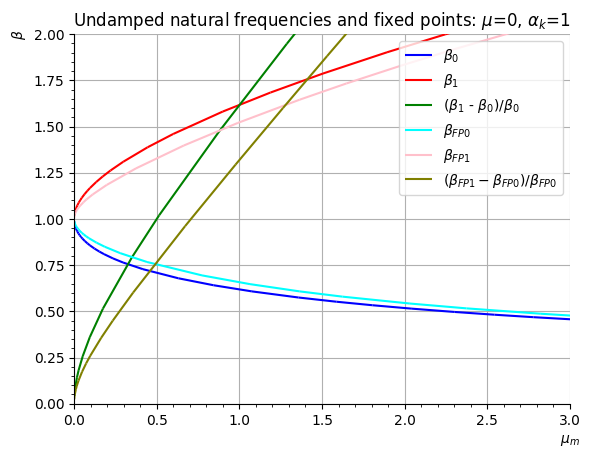

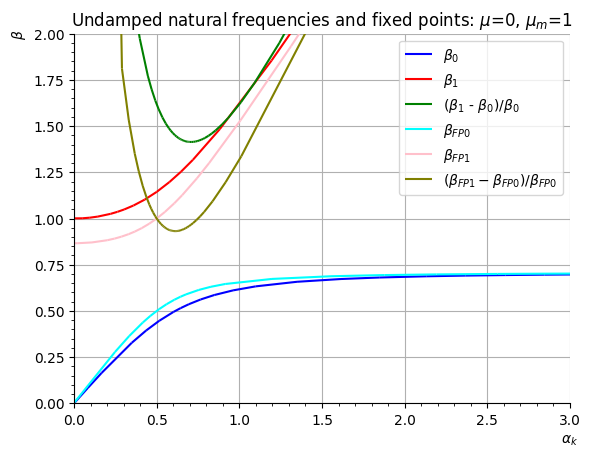

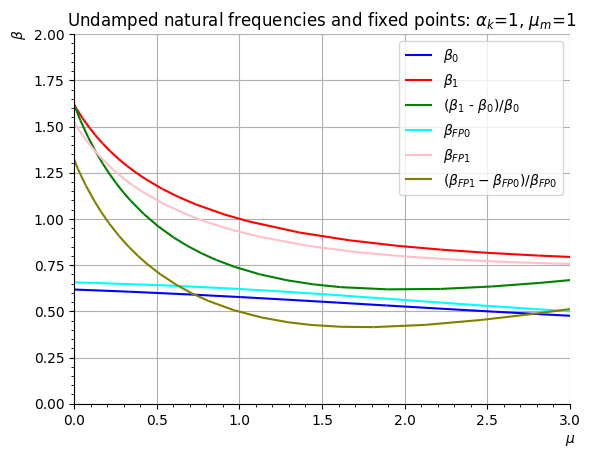

In [463]:
from sympy.plotting import plot, plot_parametric
from matplotlib import style
print(plt.style.available)

par_dict_list = [
                 {
                  # mu_m: 1, 
                  alpha_k: 1,
                  mu: 0
                  },
                 {
                  mu_m: 1, 
                  # alpha_k: alpha_k_par,
                  mu: 0
                  },
                 {
                  mu_m: 1, 
                  alpha_k: 1,
                  # mu: 0
                  }
                 ]
title_list = [r"Undamped natural frequencies and fixed points: $\mu$={}, $\alpha_k$={}"\
              .format(par_dict_list[0][mu], par_dict_list[0][alpha_k]),
              r"Undamped natural frequencies and fixed points: $\mu$={}, $\mu_m$={}"\
              .format(par_dict_list[1][mu], par_dict_list[1][mu_m]),
              r"Undamped natural frequencies and fixed points: $\alpha_k$={}, $\mu_m$={}"\
              .format(par_dict_list[2][alpha_k], par_dict_list[2][mu_m])]

for par_dict, title in zip(par_dict_list, title_list):
  style.use('default')

  p1 = plot(beta_sol[0].subs(par_dict), show=False, label=r'$\beta_0$', line_color='blue')
  p2 = plot(beta_sol[1].subs(par_dict), show=False, label=r'$\beta_1$', line_color='red')
  p3 = plot(((beta_sol[1]-beta_sol[0])/beta_sol[0]).subs(par_dict), 
            show=False, label=r'$(\beta_1$ - $\beta_0)/\beta_0$', 
            line_color='green')
  p4 = plot(beta_fixed_points[0].subs(par_dict), show=False, label=r'$\beta_{FP0}$', line_color='cyan')
  p5 = plot(beta_fixed_points[1].subs(par_dict), show=False, label=r'$\beta_{FP1}$', line_color='pink')
  p6 = plot(((beta_fixed_points[1].subs(par_dict) - beta_fixed_points[0]) / beta_fixed_points[0]).subs(par_dict), 
            show=False, 
            label=r'$(\beta_{FP1} - \beta_{FP0})/\beta_{FP0}$', 
            line_color='olive')

  p1.append(p2[0])
  p1.append(p3[0])
  p1.append(p4[0])
  p1.append(p5[0])
  p1.append(p6[0])
  # p1.append(p7[0])
  # p1.append(p8[0])
  p1.title = title
  p1.xlabel = r"$\{}$".format(p1.xlabel)
  p1.ylabel = r'$\beta$'
  p1.xlim = (0, 3)
  p1.ylim = (0, 2)
  p1.legend = 'show'

  p1.save(os.path.join(path, f'beta_and_betaFPs_{par_dict}.pdf'))
  plt.gca().grid(visible=True)
  plt.gca().minorticks_on()
  plt.savefig(os.path.join(path, f'beta_and_betaFPs_{par_dict}.pdf'))




In [464]:
H_2_FP0 = H_2.subs({beta: beta_fixed_points[0]})
H_2_FP1 = H_2.subs({beta: beta_fixed_points[1]})
H_2_FPs_diff = sm.collect((H_2_FP1 - H_2_FP0), [alpha_k, mu_m, mu])
H_2_FPs_diff = H_2_FPs_diff.subs({zeta: 0})
H_2_FPs_diff

-(alpha_k**4*(mu_m**4 + 2*mu_m**3 + mu_m**2) + alpha_k**2*(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) - sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 8*mu*mu_m + 4*mu_m**5 + mu_m**3*(-24*mu - 12) + mu_m**2*(-24*mu - 8)) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))*(-2*mu*mu_m**3 - 4*mu*mu_m**2 - 2*mu*mu_m - 2*mu_m**3 - 2*mu_m**2)/(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4)) + (mu**2 + mu_m**2*(mu**2 + 2*mu + 1) + mu_m*(2*mu**2 + 2*mu))*(alpha_k**2*(2*mu_m**3 + 4*mu_m**2 + 2*mu_m) + 2*mu + mu_m**2 + mu_m*(2*mu + 2) - sqrt(alpha_k**4*(4*mu_m**6 + 16*mu_m**5 + 24*mu_m**4 + 16*mu_m**3 + 4*mu_m**2) + alpha_k**2*(-8*mu*mu_m**4 - 8*mu*mu_m + 4*mu_m**5 + mu_m**3*(-24*mu - 12) + mu_m**2*(-24*mu - 8)) + 4*mu**2 + mu_m**4 + mu_m**3*(4*mu + 4) + mu_m**2*(4*mu**2 + 12*mu + 4) + mu_m*(8*mu**2 + 8*mu)))**2/(4*mu + mu_m**2*(4*mu + 4) + mu_m*(8*mu + 4

### Optimization of $\mu$: $\mu$ such that $|H(\beta_{FP1})| = |H(\beta_{FP0})|$


In [465]:

if optimize_anal:
  mu_m_alpha_k_cases = [
      {
          mu_m: 1,
          alpha_k: 1
      },
      {
          mu_m: sm.Rational(1, 2),
          alpha_k: 1
      },
      {
          mu_m: 1,
          alpha_k: sm.Rational(1, 2)
      },
      {
          mu_m: 2,
          alpha_k: 1        
      },
      {
          mu_m: 1,
          alpha_k: 2
      },
      {
          mu_m: 2,
          alpha_k: 2
      },
      {
          mu_m: sm.Rational(3, 4),
          alpha_k: sm.Rational(3, 4)
      }
  ]

  for mu_m_alpha_k in mu_m_alpha_k_cases: 
    H_2_FPs_diff_ = sm.simplify(H_2_FPs_diff.subs(mu_m_alpha_k))
    mu_opt_FP_ = sm.solve(H_2_FPs_diff_, mu)[0]
    mu_m_alpha_k['H_2_FPs_diff_'] = H_2_FPs_diff_
    mu_m_alpha_k['mu_opt_FP_'] = mu_opt_FP_
    mu_m_alpha_k['mu_opt_FP_float_'] = float(mu_opt_FP_)



### Optimization of $\zeta$: turn a fixed point into a frequency response peak

In [466]:
if optimize_anal:
  for mu_m_alpha_k in mu_m_alpha_k_cases: 
    D_H_2_beta_ = sm.simplify(sm.diff(H_2.subs(mu_m_alpha_k), beta))
    mu_m_alpha_k['D_H_2_beta_'] = D_H_2_beta_
    # at FP0
    D_H_2_beta_at_FP0_ = sm.simplify(
        D_H_2_beta_.subs({beta: beta_fixed_points[0].subs(mu_m_alpha_k)}))
    D_H_2_beta_at_FP0_muopt_ = sm.simplify(D_H_2_beta_at_FP0_.subs({
        mu: mu_m_alpha_k['mu_opt_FP_']}))
    mu_m_alpha_k['D_H_2_beta_at_FP0_muopt_'] = D_H_2_beta_at_FP0_muopt_
    zeta_opt_FP0_ = sm.solve(D_H_2_beta_at_FP0_muopt_, zeta)[0]
    mu_m_alpha_k['zeta_opt_FP0_'] = zeta_opt_FP0_
    # at FP1
    D_H_2_beta_at_FP1_ = sm.simplify(
        D_H_2_beta_.subs({beta: beta_fixed_points[1].subs(mu_m_alpha_k)}))
    D_H_2_beta_at_FP1_muopt_ = sm.simplify(D_H_2_beta_at_FP1_.subs({
        mu: mu_m_alpha_k['mu_opt_FP_']}))
    mu_m_alpha_k['D_H_2_beta_at_FP1_muopt_'] = D_H_2_beta_at_FP1_muopt_
    zeta_opt_FP1_ = sm.solve(D_H_2_beta_at_FP1_muopt_, zeta)[0]
    mu_m_alpha_k['zeta_opt_FP1_'] = zeta_opt_FP1_
    # average
    zeta_opt_FP_ = (zeta_opt_FP0_ + zeta_opt_FP1_)/2
    mu_m_alpha_k['zeta_opt_FP_'] = zeta_opt_FP_
    mu_m_alpha_k['zeta_opt_FP_float_'] = float(zeta_opt_FP_)

### Optimal response

In [467]:
tf12_anal_b1c1zero_omega_norm = tf_anal_b1c1zero_omega.subs(normalization_dict)
tf12_anal_b1c1zero_omega_norm = sm.factor(tf12_anal_b1c1zero_omega_norm[1], 
                                          m1, k1)
tf12_anal_b1c1zero_omega_norm = sm.collect(tf12_anal_b1c1zero_omega_norm, beta)
tf12_anal_b1c1zero_omega_norm = sm.collect(tf12_anal_b1c1zero_omega_norm, mu_m)
tf12_anal_b1c1zero_omega_norm

mu_m/(omega0**2*(beta**4*(-mu + mu_m*(-mu - 1)) + beta**3*(2*I*mu_m**2*zeta + 2*I*mu_m*zeta) + beta**2*(alpha_k**2*mu_m**2 + mu + mu_m*(alpha_k**2 + 1)) + mu_m*(-alpha_k**2 - 2*I*beta*zeta)))

In [468]:
if optimize_anal:
  H12_2 = sm.re(tf12_anal_b1c1zero_omega_norm)**2 \
      + sm.im(tf12_anal_b1c1zero_omega_norm)**2
  H12_2 = sm.factor(H12_2, zeta)
  H12_2 = sm.collect(H12_2, beta)
  H12_2

  for mu_m_alpha_k in mu_m_alpha_k_cases: 
    optimization_dict = {mu: mu_m_alpha_k['mu_opt_FP_'], 
                         zeta: mu_m_alpha_k['zeta_opt_FP_']}

    H_2_opt_ = (H_2.subs(mu_m_alpha_k)).subs(optimization_dict)
    mu_m_alpha_k['H_2_opt_'] = H_2_opt_

    H12_2_opt_ = (H12_2.subs(mu_m_alpha_k)).subs(optimization_dict)
    mu_m_alpha_k['H12_2_opt_'] = H12_2_opt_

    pseudo_resonances = [beta_fixed_points[0].subs(optimization_dict).subs(mu_m_alpha_k), 
                        beta_fixed_points[1].subs(optimization_dict).subs(mu_m_alpha_k)]

    H_opt_pseudo_peaks = \
        [float(sm.simplify(sm.sqrt(H_2_opt_.subs({beta: pseudo_resonance}))*(omega0**2)))/(omega0**2) \
        for pseudo_resonance in pseudo_resonances]
    mu_m_alpha_k['H_opt_inf_'] = max(
        [float(_*(omega0**2)) for _ in H_opt_pseudo_peaks])/(omega0**2)

    H12_opt_pseudo_peaks = \
        [float(sm.simplify(sm.sqrt(H12_2_opt_.subs({beta: pseudo_resonance}))*(omega0**2)))/(omega0**2) \
        for pseudo_resonance in pseudo_resonances]
    mu_m_alpha_k['H12_opt_inf_'] = max(
        [float(_*(omega0**2)) for _ in H12_opt_pseudo_peaks])/(omega0**2)

In [469]:
# dump and load in a pickle file
filename = os.path.join(path, 'optimization_anal_v5.pickle')
if optimize_anal:
  print('File', filename, f' is being created because optimize_anal = {optimize_anal}')
  with open(filename, "wb") as file:
    pickle.dump(mu_m_alpha_k_cases, file)
if os.path.isfile(filename):
  print('File', filename, 'exists, so it is being loaded...')
  with open(filename, "rb") as file:
    mu_m_alpha_k_cases = pickle.load(file)


File /content/drive/My Drive/TRABAJO/46_cm_inerter/TRABAJO/optimization_anal_v5.pickle exists, so it is being loaded...


### Tables of analytical results

In [470]:
string = (" \\\\ \\\\ \n").join([
    ' & '.join(['$'+sm.latex(_[mu_m])+'$', '$'+sm.latex(_[alpha_k])+'$', 
                # '$'+sm.latex(_['H_2_FPs_diff_'])+'$', 
                '$'+sm.latex(_['mu_opt_FP_'])+'$', 
                str(np.round(float(_['zeta_opt_FP_float_']), 3)), 
                '$'+sm.latex(np.round(float(_['H_opt_inf_']*omega0**2), 3))+'$', 
                '$'+sm.latex(np.round(float(_['H12_opt_inf_']*omega0**2), 3))+'$'])
      for _ in mu_m_alpha_k_cases])
print(string)
with open(os.path.join(path, 'optimization_anal_table.txt'), 'w') as f:
  print(string, file=f)


$1$ & $1$ & $\frac{7}{4}$ & 0.459 & $6.0$ & $5.123$ \\ \\ 
$\frac{1}{2}$ & $1$ & $\frac{1}{2}$ & 0.372 & $4.743$ & $5.677$ \\ \\ 
$1$ & $\frac{1}{2}$ & $\frac{1}{4}$ & 0.264 & $3.464$ & $6.679$ \\ \\ 
$2$ & $1$ & $6$ & 0.526 & $9.487$ & $5.677$ \\ \\ 
$1$ & $2$ & $\frac{31}{4}$ & 0.879 & $11.489$ & $4.502$ \\ \\ 
$2$ & $2$ & $24$ & 1.013 & $18.248$ & $5.029$ \\ \\ 
$\frac{3}{4}$ & $\frac{3}{4}$ & $\frac{843}{1792}$ & 0.331 & $4.139$ & $5.695$


In [471]:
string = (" \\\\ \\\\ \n").join([
    ' & '.join(['$'+sm.latex(_[mu_m])+'$', '$'+sm.latex(_[alpha_k])+'$', 
                # '$'+sm.latex(_['H_2_FPs_diff_'])+'$', 
                '$'+sm.latex(_['mu_opt_FP_'])+'$', 
                str(np.round(float(_['zeta_opt_FP0_']), 3)), 
                str(np.round(float(_['zeta_opt_FP1_']), 3)), 
                str(np.round(float(_['zeta_opt_FP_float_']), 3)), 
                '$'+sm.latex(np.round(float(_['H_opt_inf_']*omega0**2), 3))+'$', 
                '$'+sm.latex(np.round(float(_['H12_opt_inf_']*omega0**2), 3))+'$'])
      for _ in mu_m_alpha_k_cases])
print(string)
with open(os.path.join(path, 'optimization_anal_table.txt'), 'w') as f:
  print(string, file=f)

$1$ & $1$ & $\frac{7}{4}$ & 0.484 & 0.433 & 0.459 & $6.0$ & $5.123$ \\ \\ 
$\frac{1}{2}$ & $1$ & $\frac{1}{2}$ & 0.392 & 0.352 & 0.372 & $4.743$ & $5.677$ \\ \\ 
$1$ & $\frac{1}{2}$ & $\frac{1}{4}$ & 0.29 & 0.238 & 0.264 & $3.464$ & $6.679$ \\ \\ 
$2$ & $1$ & $6$ & 0.554 & 0.498 & 0.526 & $9.487$ & $5.677$ \\ \\ 
$1$ & $2$ & $\frac{31}{4}$ & 0.905 & 0.854 & 0.879 & $11.489$ & $4.502$ \\ \\ 
$2$ & $2$ & $24$ & 1.041 & 0.986 & 1.013 & $18.248$ & $5.029$ \\ \\ 
$\frac{3}{4}$ & $\frac{3}{4}$ & $\frac{843}{1792}$ & 0.354 & 0.308 & 0.331 & $4.139$ & $5.695$


### Numerical solutions

In [472]:
from itertools import product
from sympy import lambdify

min_val = 0.1
max_val = 2.0
step_val = 0.1
if optimize_anal_num:
  mu_m_alpha_k_cases_num = [
      {
          mu_m: mu_m_alpha_k_[0],
          alpha_k: mu_m_alpha_k_[1],
          omega0: 1
      } for mu_m_alpha_k_ in 
      list(product(np.arange(min_val, max_val + step_val, step_val), 
                   np.arange(min_val, max_val + step_val, step_val)))
  ]

  H12_2 = sm.re(tf12_anal_b1c1zero_omega_norm)**2 \
      + sm.im(tf12_anal_b1c1zero_omega_norm)**2
  H12_2 = sm.factor(H12_2, zeta)
  H12_2 = sm.collect(H12_2, beta)
  H12_2

  for mu_m_alpha_k in mu_m_alpha_k_cases_num: 
    # mu_opt
    H_2_FPs_diff_ = H_2_FPs_diff.subs(mu_m_alpha_k)
    H_2_FPs_diff_fun = lambdify(mu, H_2_FPs_diff_.subs(mu_m_alpha_k))
    mu_opt_FP_ = sp.optimize.bisect(H_2_FPs_diff_fun, -1, 25)
    mu_m_alpha_k['mu_opt_FP_float_'] = np.round(mu_opt_FP_, 6)

    # zeta_opt
    D_H_2_beta_ = sm.diff(H_2.subs(mu_m_alpha_k), beta)
    # at FP0
    D_H_2_beta_at_FP0_ = D_H_2_beta_.subs({beta: beta_fixed_points[0].subs(mu_m_alpha_k)})
    D_H_2_beta_at_FP0_muopt_fun = lambdify(zeta, D_H_2_beta_at_FP0_.subs({
        mu: mu_m_alpha_k['mu_opt_FP_float_']}))
    zeta_opt_FP0_ = sp.optimize.bisect(D_H_2_beta_at_FP0_muopt_fun, 0, 1.5)
    mu_m_alpha_k['zeta_opt_FP0_float_'] = zeta_opt_FP0_
    # at FP1
    D_H_2_beta_at_FP1_ = D_H_2_beta_.subs({beta: beta_fixed_points[1].subs(mu_m_alpha_k)})
    D_H_2_beta_at_FP1_muopt_fun = lambdify(zeta, D_H_2_beta_at_FP1_.subs({
        mu: mu_m_alpha_k['mu_opt_FP_float_']}))
    zeta_opt_FP1_ = sp.optimize.bisect(D_H_2_beta_at_FP1_muopt_fun, 0, 1.5)
    mu_m_alpha_k['zeta_opt_FP1_float_'] = zeta_opt_FP1_
    # average
    zeta_opt_FP_ = (zeta_opt_FP0_ + zeta_opt_FP1_)/2
    mu_m_alpha_k['zeta_opt_FP_float_'] = np.round((zeta_opt_FP0_ + zeta_opt_FP1_)/2, 6)

    # optimal response
    optimization_dict = {mu: mu_m_alpha_k['mu_opt_FP_float_'], 
                         zeta: mu_m_alpha_k['zeta_opt_FP_float_']}

    H_2_opt_ = (H_2.subs(mu_m_alpha_k)).subs(optimization_dict)
    mu_m_alpha_k['H_2_opt_'] = H_2_opt_

    H12_2_opt_ = (H12_2.subs(mu_m_alpha_k)).subs(optimization_dict)
    mu_m_alpha_k['H12_2_opt_'] = H12_2_opt_

    pseudo_resonances = [beta_fixed_points[0].subs(optimization_dict).subs(mu_m_alpha_k), 
                        beta_fixed_points[1].subs(optimization_dict).subs(mu_m_alpha_k)]

    H_opt_pseudo_peaks = \
        [float(sm.sqrt(H_2_opt_.subs({beta: pseudo_resonance}))) \
        for pseudo_resonance in pseudo_resonances]
    mu_m_alpha_k['H_opt_inf_float_'] = max(
        [float(_) for _ in H_opt_pseudo_peaks])

    H12_opt_pseudo_peaks = \
        [float(sm.sqrt(H12_2_opt_.subs({beta: pseudo_resonance}))) \
        for pseudo_resonance in pseudo_resonances]
    mu_m_alpha_k['H12_opt_inf_float_'] = max(
        [float(_) for _ in H12_opt_pseudo_peaks])

In [473]:
# dump and load in a pickle file
filename = os.path.join(path, 'optimization_anal_num_v6.pickle')
if optimize_anal_num:
  print('File', filename, f' is being created because optimize_anal_num = {optimize_anal_num}')
  with open(filename, "wb") as file:
    pickle.dump(mu_m_alpha_k_cases_num, file)
if os.path.isfile(filename):
  print('File', filename, 'exists, so it is being loaded...')
  with open(filename, "rb") as file:
    mu_m_alpha_k_cases_num = pickle.load(file)

File /content/drive/My Drive/TRABAJO/46_cm_inerter/TRABAJO/optimization_anal_num_v6.pickle exists, so it is being loaded...


In [474]:
# for mu_m_alpha_k in mu_m_alpha_k_cases_num: 
#   print(np.round(mu_m_alpha_k[mu_m], 5), 
#         np.round(mu_m_alpha_k[alpha_k], 5), 
#         np.round(mu_m_alpha_k['mu_opt_FP_float_'], 5), 
#         np.round(mu_m_alpha_k['zeta_opt_FP0_float_'], 5), 
#         np.round(mu_m_alpha_k['zeta_opt_FP1_float_'], 5), 
#         np.round(mu_m_alpha_k['zeta_opt_FP_float_'], 5), 
#         np.round(mu_m_alpha_k['H_opt_inf_float_'], 5), 
#         np.round(mu_m_alpha_k['H12_opt_inf_float_'], 5))

### Nomograms from analytical-numerical results


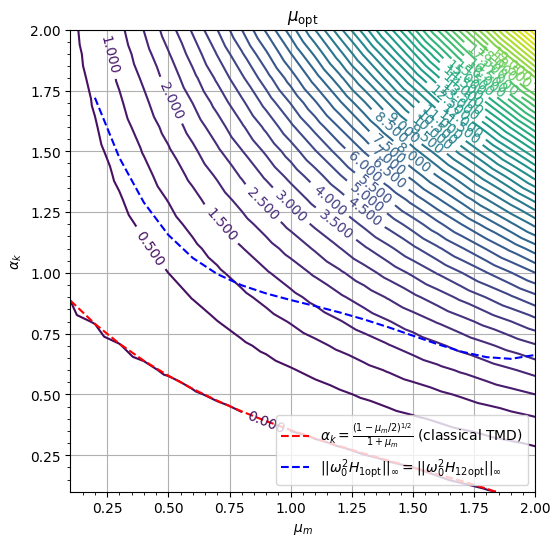

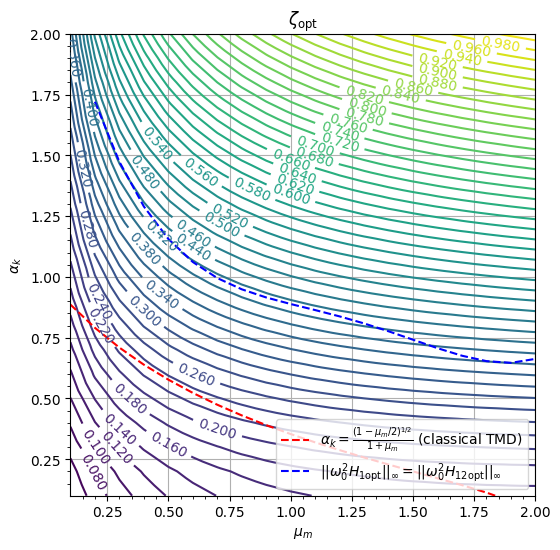

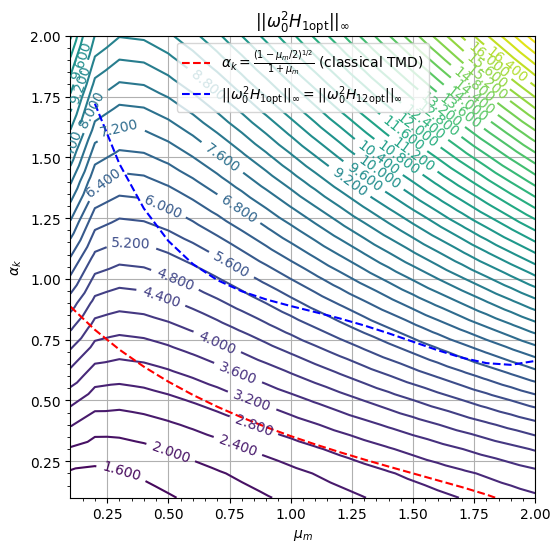

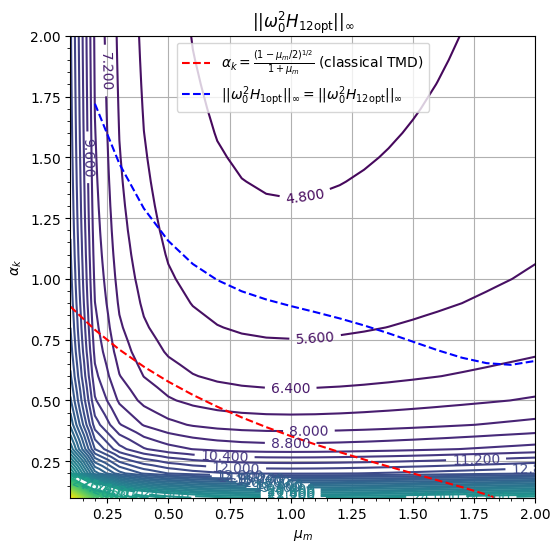

In [475]:
mu_m_contour = np.array([float(_[mu_m]) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))
alpha_k_contour = np.array([float(_[alpha_k]) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))
mu_opt_contour = np.array([float(_['mu_opt_FP_float_']) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))
zeta_opt_contour = np.array([float(_['zeta_opt_FP_float_']) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))
H_opt_contour = np.array([float(_['H_opt_inf_float_']) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))
H12_opt_contour = np.array([float(_['H12_opt_inf_float_']) for _ in mu_m_alpha_k_cases_num]).reshape((-1, ))

def intersect(z1, z2, tol):
  abs_dif = np.abs(z1-z2)
  if abs_dif < tol:
    return True
  else:
    return False

intersect_vect = np.vectorize(intersect)
z1z2 = intersect_vect(H_opt_contour, H12_opt_contour, 1)
mu_m_intersect, alpha_k_intersect = mu_m_contour[z1z2], alpha_k_contour[z1z2]
alpha_k_intersect = np.polyval(np.polyfit(mu_m_intersect, alpha_k_intersect, 4), 
                               mu_m_intersect)


def plot_contour(x, y, z, x_inter, y_inter, title, filename=None):
  # levels = 20 if filename == 'anal_num_H12_opt.pdf' else 50
  levels = 50

  index_sort = np.argsort(z)
  fig, ax = plt.subplots(figsize=[6, 6])
  ax.minorticks_on()
  CS = ax.tricontour(x[index_sort], y[index_sort], z[index_sort],
                     levels=levels)
  ax.clabel(CS, inline=1, fontsize=10)
  ax.set_xlabel(r'$\mu_m$')
  ax.set_ylabel(r'$\alpha_k$')
  ax.set_title(title)
  ax.grid(True)

  xlim_, ylim_ = ax.get_xlim(), ax.get_ylim()
  mu_m_limit_case = x
  alpha_k_limit_case = (1-mu_m_limit_case/2)**(1/2)/(1 + mu_m_limit_case)
  ax.plot(mu_m_limit_case, alpha_k_limit_case, 
          color='red', linestyle='--', label=r'$\alpha_k=\frac{(1-\mu_m/2)^{1/2}}{1 + \mu_m}$ (classical TMD)')
  ax.plot(x_inter, y_inter, 
          color='blue', linestyle='--', 
          label=r'$||\omega_0^2 H_\mathrm{1opt}||_{\infty} = ||\omega_0^2 H_\mathrm{12opt}||_{\infty}$')
  ax.set_xlim(xlim_)
  ax.set_ylim(ylim_)
  if filename in ['anal_num_H1_opt.pdf', 'anal_num_H12_opt.pdf'] :
    ax.legend(loc='upper center')
  else:
    ax.legend(loc='lower right')

  if filename is not None:
    fig.savefig(os.path.join(path, filename))


plot_contour(mu_m_contour, alpha_k_contour, mu_opt_contour,
             mu_m_intersect, alpha_k_intersect,
             r'$\mu_\mathrm{opt}$', 'anal_num_mu_opt.pdf')
plot_contour(mu_m_contour, alpha_k_contour, zeta_opt_contour,
             mu_m_intersect, alpha_k_intersect,
             r'$\zeta_\mathrm{opt}$', 'anal_num_zeta_opt.pdf')
plot_contour(mu_m_contour, alpha_k_contour, H_opt_contour,
             mu_m_intersect, alpha_k_intersect,
             r'$||\omega_0^2 H_\mathrm{1opt}||_{\infty}$', 'anal_num_H1_opt.pdf')
plot_contour(mu_m_contour, alpha_k_contour, H12_opt_contour,
             mu_m_intersect, alpha_k_intersect,
             r'$||\omega_0^2 H_\mathrm{12opt}||_{\infty}$', 'anal_num_H12_opt.pdf')


## Tests

### Test model with uniform mass and stiffness

In [476]:
## constans
# stiffness-proportional damping coefficient
alpha = 0.02

k1_c = 1
c1_c = alpha*k1_c
m1_c = 1
k12_c = 1
c12_c = alpha*k12_c
m2_c = 1
b1_c = 0
b12_c = 0

alpha_k_c = np.sqrt(k1_c/m1_c)/np.sqrt(k12_c/m2_c)

base_parameters = {'k1':  k1_c,
                   'c1':  c1_c,
                   'm1':  m1_c,
                   'k12': k12_c,
                   'c12': c12_c,
                   'm2':  m2_c,
                   'b1':  b1_c,
                   'b12': b12_c}

par_test_uniform = Parameters(base_parameters)

i_output = 0
tf_test_uniform = TF(A, B, C, D).subs(i_output, par_test_uniform.get_parameters(alpha,0,0))

tf_test_uniform_opt_num = TF(A, B, C, D).subs(i_output, par_test_uniform.get_parameters(alpha,1.77,0.98))

omega0_c = np.sqrt(k1_c/m1_c)
b12_opt_approx = m1_c * 7/4
c12_opt_approx = 2*m1_c*omega0_c * 0.459
H_inf_opt_approx = 6.0 / omega0_c**2
H12_inf_opt_approx = 5.123 / omega0_c**2
tf_test_uniform_opt_anal = TF(A, B, C, D).subs(i_output, 
                                               par_test_uniform.get_parameters(
                                                   alpha,
                                                   b12_opt_approx,
                                                   c12_opt_approx))

# benchmark classical BMD
b12_opt_BMD = 0.0
c12_opt_BMD = 0.5*(.20+.22) * 2*m1_c*omega0_c
alpha_k_opt_BMD = 0.35
k12_add_BMD = (alpha_k_opt_BMD**2 - alpha_k_c**2) * m2_c * omega0_c**2

tf_test_uniform_opt_BMD = TF(A, B, C, D).subs(i_output, 
                                           par_test_uniform.get_parameters(
                                               alpha,
                                               b12_opt_BMD,
                                               c12_opt_BMD,
                                               k12_add=k12_add_BMD))

w = tf_test_uniform.natural_w(par_test_uniform.get_parameters(alpha, 0, 0))
print(f"no control: omegas={w}, BMD: "
      f"omegas={tf_test_uniform_opt_BMD.natural_w(par_test_uniform.get_parameters(alpha, b12_opt_BMD, c12_opt_BMD, k12_add=k12_add_BMD))}")

no control: omegas=[0.61802219 1.61782217], BMD: omegas=[0.30189919 0.92720079]


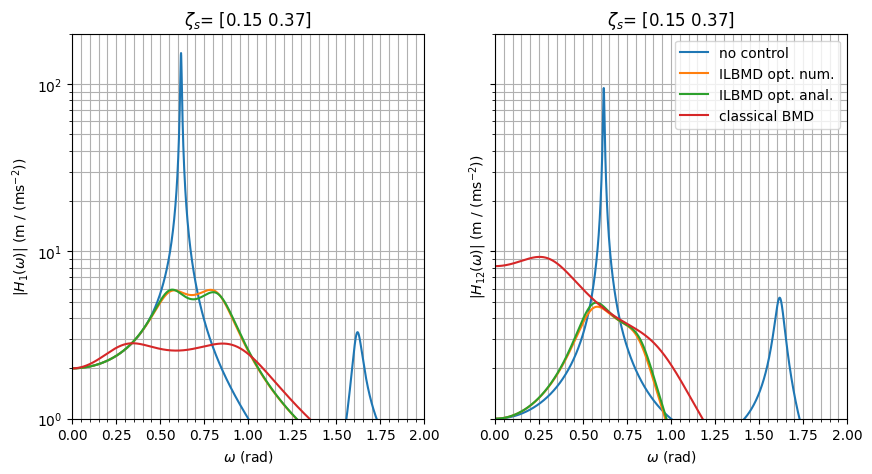

In [494]:
H_lims = (1.0, 200)
# H_lims = (4, 7)
ylabels = ['$|H_1(\omega)|$ (m / (ms$^{-2}$))', '$|H_{12}(\omega)|$ (m / (ms$^{-2}$))']

fig, ax = plt.subplots(1, 2, figsize=[10, 5], sharey='row')

for i_output, ylabel in zip([0, 1], ylabels):
  ax[i_output].minorticks_on()
  ax[i_output].grid(True, which='both')
  ax[i_output].plot(tf_test_uniform._freqresp_w, 
                    np.abs(tf_test_uniform.subs(i_output=i_output)._freqresp_H),
                    label='no control')
  ax[i_output].plot(tf_test_uniform_opt_num._freqresp_w, 
                    np.abs(tf_test_uniform_opt_num.subs(i_output=i_output)._freqresp_H),
                    label='ILBMD opt. num.')
  ax[i_output].plot(tf_test_uniform_opt_anal._freqresp_w, 
                    np.abs(tf_test_uniform_opt_anal.subs(i_output=i_output)._freqresp_H),
                    label='ILBMD opt. anal.')
  ax[i_output].plot(tf_test_uniform_opt_BMD._freqresp_w, 
                    np.abs(tf_test_uniform_opt_BMD.subs(i_output=i_output)._freqresp_H),
                    label='classical BMD')
  ax[i_output].set_xlim([0, 2])
  ax[i_output].set_ylim(H_lims)
  ax[i_output].set_xlabel('$\omega$ (rad)')
  ax[i_output].set_ylabel(ylabel)
  ax[i_output].set_yscale('log')
  ax[i_output].set_title(r'$\zeta_s$' + f"= {np.round(w*alpha/2,2)}")
ax[i_output].legend();

fig.savefig(os.path.join(path, "num_example_uniform.pdf"))


### Test model for experimental campaing

In [478]:
m1_exp = 32.37
m2_exp = 26.007
k1_exp = 14188
k12_exp = 19904

mu_m_exp = m2_exp/m1_exp
omega0_exp = np.sqrt(k1_exp/m1_exp)
alpha_k_exp = np.sqrt(k12_exp/m2_exp) / omega0_exp

print(f"{omega0_exp=}, {mu_m_exp=}, {alpha_k_exp=}")


b12_opt_approx = 0.5*(2.0+2.5) * m1_exp
c12_opt_approx = 0.54 * 2*m1_exp*omega0_exp
H_inf_opt_approx = 6.8 / omega0_exp**2
H12_inf_opt_approx = 0.5*(4.8 + 5.6) / omega0_exp**2

print('optimal inertance: ', b12_opt_approx, ' kg')
print('optimal damping coefficient: ', c12_opt_approx, ' Ns/m')
print('optimal H_inf: ', H_inf_opt_approx, ' m / (m/s2)')
print('optimal H12_inf: ', H12_inf_opt_approx, ' m / (m/s2)')


## constans
# stiffness-proportional damping coefficient
alpha_exp = 0.0022

base_parameters_exp = {
    'k1':  k1_exp,
    'c1':  alpha_exp*k1_exp,
    'm1':  m1_exp,
    'k12': k12_exp,
    'c12': alpha_exp*k12_exp,
    'm2':  m2_exp,
    'b1':  0,
    'b12': 0}

par_test_exp = Parameters(base_parameters_exp)

i_output = 0
tf_test_exp = TF(A, B, C, D, w = np.linspace(0, 100, 10000)).subs(i_output, par_test_exp.get_parameters(alpha_exp,0,0))

tf_test_exp_opt_num = TF(A, B, C, D, w = np.linspace(0, 100, 10000)).subs(i_output, par_test_exp.get_parameters(
    alpha_exp,
    75.0,
    710.4))

tf_test_exp_opt_anal = TF(A, B, C, D, w = np.linspace(0, 100, 10000)).subs(i_output, 
                                           par_test_exp.get_parameters(
                                               alpha_exp,
                                               b12_opt_approx,
                                               c12_opt_approx))

# benchmark classical BMD
b12_opt_BMD = 0.0
c12_opt_BMD = 0.5*(.22+.24) * 2*m1_exp*omega0_exp
alpha_k_opt_BMD = 0.5*(.40 + .45)
k12_add_BMD = (alpha_k_opt_BMD**2 - alpha_k_exp**2) * m2_exp * omega0_exp**2

tf_test_exp_opt_BMD = TF(A, B, C, D, w = np.linspace(0, 100, 10000)).subs(i_output, 
                                           par_test_exp.get_parameters(
                                               alpha_exp,
                                               b12_opt_BMD,
                                               c12_opt_BMD,
                                               k12_add=k12_add_BMD))

w = tf_test_exp.natural_w(par_test_exp.get_parameters(alpha_exp, 0, 0))
print(f"no control: omegas={w}, BMD: omegas={tf_test_exp_opt_BMD.natural_w(par_test_exp.get_parameters(alpha_exp, b12_opt_BMD, c12_opt_BMD, k12_add=k12_add_BMD))}")

omega0_exp=20.935784543495206, mu_m_exp=0.8034291010194625, alpha_k_exp=1.3214045943847286
optimal inertance:  72.8325  kg
optimal damping coefficient:  731.9066533267751  Ns/m
optimal H_inf:  0.015514237383704537  m / (m/s2)
optimal H12_inf:  0.011863828587538762  m / (m/s2)
no control: omegas=[14.43176468 40.08820578], BMD: omegas=[ 6.98836435 17.37112418]


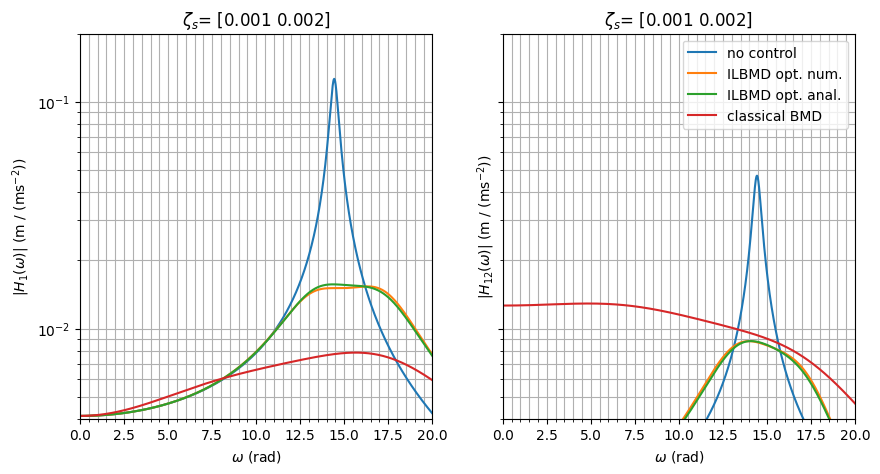

In [495]:
H_lims = (.004, .200)
w_lims = (0, 20)

ylabels = ['$|H_1(\omega)|$ (m / (ms$^{-2}$))', '$|H_{12}(\omega)|$ (m / (ms$^{-2}$))']

fig, ax = plt.subplots(1, 2, figsize=[10, 5], sharey='row')

for i_output, ylabel in zip([0, 1], ylabels):
  ax[i_output].minorticks_on()
  ax[i_output].grid(True, which='both')
  ax[i_output].plot(tf_test_exp._freqresp_w, 
                    np.abs(tf_test_exp.subs(i_output=i_output)._freqresp_H),
                    label='no control')
  ax[i_output].plot(tf_test_exp_opt_num._freqresp_w, 
                    np.abs(tf_test_exp_opt_num.subs(i_output=i_output)._freqresp_H),
                    label='ILBMD opt. num.')
  ax[i_output].plot(tf_test_exp_opt_anal._freqresp_w, 
                    np.abs(tf_test_exp_opt_anal.subs(i_output=i_output)._freqresp_H),
                    label='ILBMD opt. anal.')
  ax[i_output].plot(tf_test_exp_opt_BMD._freqresp_w, 
                    np.abs(tf_test_exp_opt_BMD.subs(i_output=i_output)._freqresp_H),
                    label='classical BMD')
  ax[i_output].set_xlim(w_lims)
  ax[i_output].set_ylim(H_lims)
  ax[i_output].set_xlabel('$\omega$ (rad)')
  ax[i_output].set_ylabel(ylabel)
  ax[i_output].set_yscale('log')
  ax[i_output].set_title(r'$\zeta_s$' + f"= {np.round(w*alpha_exp/2,3)}")
ax[i_output].legend();

fig.savefig(os.path.join(path, "num_example_exp.pdf"))


# Parametric analysis

## Base parameters

In [480]:
## constans
# stiffness-proportional damping coefficient
alpha = 0.02

k1_c = 1
c1_c = alpha*k1_c
m1_c = 1
k12_c = 1
c12_c = alpha*k12_c
m2_c = 1
b1_c = 0
b12_c = 0

base_parameters = {'k1':  k1_c,
                   'c1':  c1_c,
                   'm1':  m1_c,
                   'k12': k12_c,
                   'c12': c12_c,
                   'm2':  m2_c,
                   'b1':  b1_c,
                   'b12': b12_c}

par = Parameters(base_parameters)

i_output = 0
tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha,0,0))
print(tf._tf)

TransferFunctionContinuous(
array([-1.  , -0.04, -2.  ]),
array([1.    , 0.06  , 3.0004, 0.04  , 1.    ]),
dt: None
)


In [481]:
par.base_parameters

{'k1': 1,
 'c1': 0.02,
 'm1': 1,
 'k12': 1,
 'c12': 0.02,
 'm2': 1,
 'b1': 0,
 'b12': 0}

## Functions

In [482]:
steps = 50
c12_add = np.linspace(0, 250*c1_c, steps)
b12_add = np.linspace(0, 5, steps)

tf = TF(A, B, C, D)
H_1inf_b12_add = lambda x : tf.H_inf(0, 
                                     par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
H_1inf_c12_add = lambda x : tf.H_inf(0, 
                                     par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))
H_12inf_b12_add = lambda x : tf.H_inf(1,
                                      par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
H_12inf_c12_add = lambda x : tf.H_inf(1, 
                                      par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))

def damping_ratio(alpha, w):
  return alpha*w/2

natural_freqs = tf.natural_w(par.get_parameters(alpha=alpha, b12_add=0, c12_add=0))
print(f'natural frequencies = {natural_freqs} rad/s')
print(f'damping ratios = {[damping_ratio(alpha,w) for w in natural_freqs]}')

natural frequencies = [0.61802219 1.61782217] rad/s
damping ratios = [0.006180221852383058, 0.016178221714864917]


## Plots

Text(0.5, 0, '$b_{12add}$')

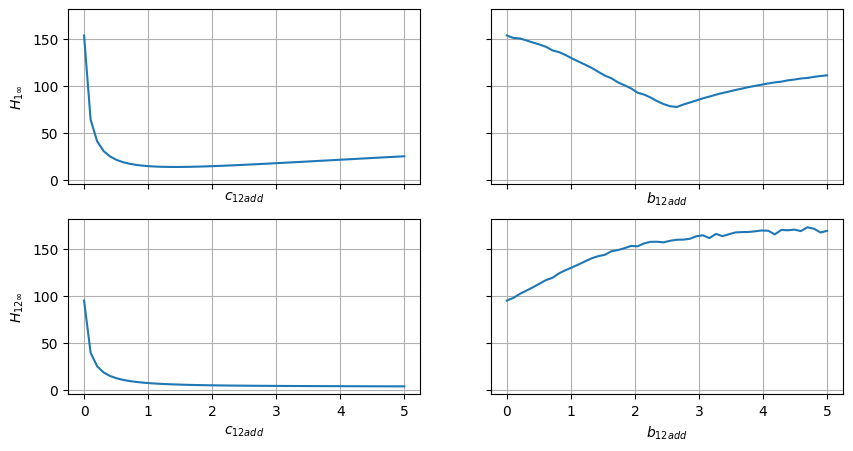

In [483]:
fig, ax = plt.subplots(2, 2, figsize=[10, 5], sharex=True, sharey=True)

[[elem.grid(which='both', axis='both') for elem in row] for row in ax]

ax[0,0].plot(c12_add, np.vectorize(H_1inf_c12_add)(c12_add))
ax[0,0].set_xlabel('$c_{12add}$')
ax[0,0].set_ylabel('$H_{1\infty}$')
ax[0,1].plot(b12_add, np.vectorize(H_1inf_b12_add)(b12_add))
ax[0,1].set_xlabel('$b_{12add}$')

ax[1,0].plot(c12_add, np.vectorize(H_12inf_c12_add)(c12_add))
ax[1,0].set_xlabel('$c_{12add}$')
ax[1,0].set_ylabel('$H_{12\infty}$')
ax[1,1].plot(b12_add, np.vectorize(H_12inf_b12_add)(b12_add))
ax[1,1].set_xlabel('$b_{12add}$')


# Multi objective optimization

## Functions

In [484]:
def optim_H_1_H_12_inf(tf, alpha, lambda_opt=1, n_iter_over2=3):
  assert 0 <= lambda_opt <= 1
  H_1_H_12_inf_c12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=0, c12_add=x)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=0, c12_add=x))
  H_1_H_12_inf_b12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=x, c12_add=0)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=x, c12_add=0))
  tfs = [copy.deepcopy(tf)]
  for i_iter in range(n_iter_over2):
    b12 = sp.optimize.minimize_scalar(H_1_H_12_inf_b12_add).x
    H_1_H_12_inf_c12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=b12, c12_add=x)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=b12, c12_add=x))
    tfs.append(copy.deepcopy(tf))
    c12 = sp.optimize.minimize_scalar(H_1_H_12_inf_c12_add).x
    H_1_H_12_inf_b12_add = lambda x : lambda_opt * tf.H_inf(0, par.get_parameters(alpha=alpha, b12_add=x, c12_add=c12)) + (1-lambda_opt) * tf.H_inf(1, par.get_parameters(alpha=alpha, b12_add=x, c12_add=c12))
    tfs.append(copy.deepcopy(tf))
  return tfs

## Single objective

In [485]:
tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
tfs = optim_H_1_H_12_inf(tf, alpha, lambda_opt=1)

### Plots

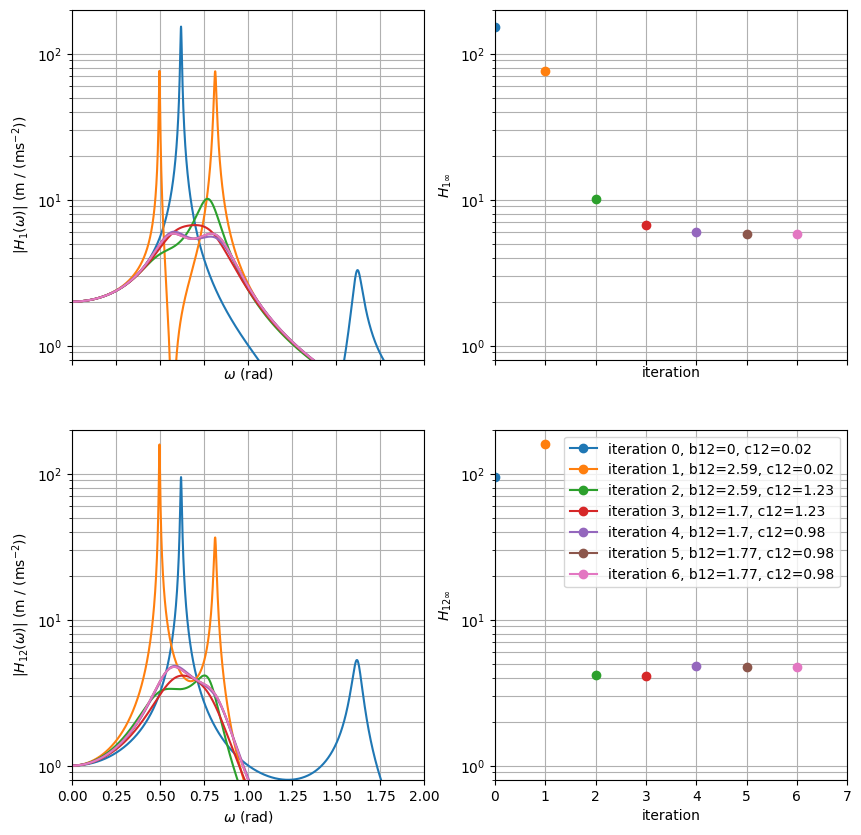

In [486]:
plot_zp = False
H_lims = (.8, 200)

if plot_zp:
  fig, ax = plt.subplots(2, 3, figsize=[15, 10], sharex='col')
  zp_iterations = [0, 1, 6]
else:
  fig, ax = plt.subplots(2, 2, figsize=[10, 10], sharex='col')
  zp_iterations = []

for i, tf in enumerate(tfs):
  i_output = 0
  tf.subs(i_output=i_output)
  ax[0,0].plot(tf._freqresp_w, np.abs(tf._freqresp_H))
  ax[0,0].set_xlim([0, 2])
  ax[0,0].set_ylim(H_lims)
  ax[0,0].set_xlabel('$\omega$ (rad)')
  ax[0,0].set_ylabel('$|H_1(\omega)|$ (m / (ms$^{-2}$))')
  ax[0,0].set_yscale('log')
  ax[0,1].plot(i, tf.H_inf(), marker='o')
  ax[0,1].set_ylabel('$H_{1\infty}$')
  ax[0,1].set_xlabel('iteration')
  ax[0,1].set_xlim([0, len(tfs)])
  ax[0,1].set_ylim(H_lims)
  ax[0,1].set_yscale('log')
  if i in zp_iterations:
    last_color = ax[0,1].lines[-1].get_color()
    print(last_color)
    zpk = sg.ss2zpk(A=tf.A_num, B=tf.B_num, C=tf.C_num[i_output], D=tf.D_num[i_output])
    z, p = zpk[0], zpk[1]
    ax[0,2].plot(np.real(z), np.imag(z), marker='o', linestyle='', 
                 color=last_color, mfc='none')
    ax[0,2].plot(np.real(p), np.imag(p), marker='x', linestyle='', 
                 color=last_color, mfc='none')
    ax[0,2].plot([-10, 10], [0, 0], color='black')
    ax[0,2].plot([0, 0], [-10, 10], color='black')
    ax[0,2].set_ylabel('$H_{1\infty}$')
    ax[0,2].set_xlabel(r'$\sigma$')
    ax[0,2].set_ylabel(r'j $\omega$')
    ax[0,2].set_xlim([-.3, .01])
    ax[0,2].set_ylim([-.05, 2])
  
  i_output = 1
  tf.subs(i_output=i_output)
  ax[1,0].plot(tf._freqresp_w, np.abs(tf._freqresp_H), label=f"iteration {i}")
  ax[1,0].set_xlabel('$\omega$ (rad)')
  ax[1,0].set_ylabel('$|H_{12}(\omega)|$ (m / (ms$^{-2}$))')
  ax[1,0].set_xlim([0, 2])
  ax[1,0].set_ylim(H_lims)
  ax[1,0].set_yscale('log')
  ax[1,1].plot(i, tf.H_inf(), marker='o', 
               label=f"iteration {i}, b12={round(tf.parameters['b12'],2)}, c12={round(tf.parameters['c12'],2)}")
  ax[1,1].set_ylabel('$H_{12 \infty}$')
  ax[1,1].set_xlabel('iteration')
  ax[1,1].legend()
  ax[1,1].set_xlim([0, len(tfs)])
  ax[1,1].set_ylim(H_lims)
  ax[1,1].set_yscale('log')
  if i in zp_iterations:
    last_color = ax[0,1].lines[-1].get_color()
    print(last_color)
    zpk = sg.ss2zpk(A=tf.A_num, B=tf.B_num, C=tf.C_num[i_output], D=tf.D_num[i_output])
    z, p = zpk[0], zpk[1]
    ax[1,2].plot(np.real(z), np.imag(z), marker='o', linestyle='', 
                 color=last_color, mfc='none')
    ax[1,2].plot(np.real(p), np.imag(p), marker='x', linestyle='', 
                 color=last_color, mfc='none')
    ax[1,2].plot([-10, 10], [0, 0], color='black')
    ax[1,2].plot([0, 0], [-10, 10], color='black')
    ax[1,2].set_ylabel('$H_{1\infty}$')
    ax[1,2].set_xlabel(r'$\sigma$')
    ax[1,2].set_ylabel(r'j $\omega$')
    ax[1,2].set_xlim([-.3, .01])
    ax[1,2].set_ylim([-.05, 2])

[[ax[i,j].grid(visible=True, which='both', axis='both') 
for i in range(2)] for j in range(2)]
plt.savefig(os.path.join(path,'FRFs_H1_opt.pdf'), bbox_inches='tight')
plt.show()

## Multi objective (Pareto front)

In [487]:

alpha_p = np.linspace(0.1,1,10)
lambda_opt_p = np.linspace(0,1,11)
if run_multiobj_optimization:
  tfs_p = {}
  for i_alpha, alpha in enumerate(alpha_p):
    print(f"Case of alpha = {alpha} ({i_alpha+1}/{len(alpha_p)})")
    front = []
    for lambda_opt in lambda_opt_p:
      print(f"  Optimizing with lambda_opt = {lambda_opt} ...")
      tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
      tfs = optim_H_1_H_12_inf(tf, alpha=alpha, lambda_opt=lambda_opt)
      front.append(tfs[-1])
    tfs_p.update({alpha: front})


In [488]:
# dump and load in a pickle file
filename = os.path.join(path, 'pareto_raw.pickle')
if os.path.isfile(filename) == False:
  print('File', filename, 'does not exist, so it is being created...')
  with open(filename, "wb") as file:
    pickle.dump(tfs_p, file)
else:
  print('File', filename, 'exists, so it is being loaded...')
  with open(filename, "rb") as file:
    tfs_p = pickle.load(file)


File /content/drive/My Drive/TRABAJO/46_cm_inerter/TRABAJO/pareto_raw.pickle exists, so it is being loaded...


In [489]:
pareto_front_p = {}
for alpha in alpha_p:
  pareto_front = np.asarray([[tf.H_inf(i_output=0), tf.H_inf(i_output=1)] for tf in tfs_p[alpha]])
  pareto_front = pareto_front[pareto_front[:,0].argsort()]
  pareto_front_p.update({alpha: pareto_front})
  # print(f"alpha = {alpha}")
  # print(pareto_front)

### Benchmark cases

In [490]:

steps = 50
c12_add = np.linspace(0, 200*c1_c, steps)
b12_add = np.linspace(0, 20, steps)
k12_add = np.linspace(0, 20*k1_c, steps)
k12_sub = np.linspace(-k1_c, 0, steps)

if run_benchmark:

  benchmark_damper_p = {}
  benchmark_inerter_p = {}
  benchmark_stiffener_p = {}
  benchmark_softening_p = {}

  for i_alpha, alpha in enumerate(alpha_p):
    print(f"Case of alpha = {alpha} ({i_alpha+1}/{len(alpha_p)})")
    H_1inf_b12_add = lambda x : tf.H_inf(0, 
                                        par.get_parameters(alpha=alpha, b12_add=x))
    H_1inf_c12_add = lambda x : tf.H_inf(0,
                                        par.get_parameters(alpha=alpha, c12_add=x))
    H_1inf_k12_add = lambda x : tf.H_inf(0,
                                        par.get_parameters(alpha=alpha, k12_add=x))  
    H_12inf_b12_add = lambda x : tf.H_inf(1,
                                          par.get_parameters(alpha=alpha, b12_add=x))
    H_12inf_c12_add = lambda x : tf.H_inf(1, 
                                          par.get_parameters(alpha=alpha, c12_add=x))
    H_12inf_k12_add = lambda x : tf.H_inf(1,
                                          par.get_parameters(alpha=alpha, k12_add=x))   
    # Damper only
    benchmark_damper =  np.hstack((np.vectorize(H_1inf_c12_add)(c12_add).reshape(-1,1), np.vectorize(H_12inf_c12_add)(c12_add).reshape(-1,1)))
    benchmark_damper_p.update({alpha: benchmark_damper})
    # Inerter only
    benchmark_inerter = np.hstack((np.vectorize(H_1inf_b12_add)(b12_add).reshape(-1,1), np.vectorize(H_12inf_b12_add)(b12_add).reshape(-1,1)))
    benchmark_inerter_p.update({alpha: benchmark_inerter})  
    # Stiffener only
    benchmark_stiffener = np.hstack((np.vectorize(H_1inf_k12_add)(k12_add).reshape(-1,1), np.vectorize(H_12inf_k12_add)(k12_add).reshape(-1,1)))
    benchmark_stiffener_p.update({alpha: benchmark_stiffener})
    # Softening only
    benchmark_softening = np.hstack((np.vectorize(H_1inf_k12_add)(k12_sub).reshape(-1,1), np.vectorize(H_12inf_k12_add)(k12_sub).reshape(-1,1)))
    benchmark_softening_p.update({alpha: benchmark_softening})


In [491]:
# dump and load in a pickle file
filename_benchmark = os.path.join(path, 'benchmark_cases.pickle')

try:
  print(f"benchmark_damper is defined and is: {benchmark_damper[0:3]} ...")
  save_benchmark = True
except NameError:
  print("benchmark_damper is not defined")
  save_benchmark = False

if save_benchmark:
  print('File', filename_benchmark, 'file is being created...')
  if 'tfs_p' in dir():
    with open(filename_benchmark, "wb") as file_benchmark:
      pickle.dump({
          'benchmark_damper': benchmark_damper,
          'benchmark_damper_p': benchmark_damper_p,
          'benchmark_inerter': benchmark_inerter,
          'benchmark_inerter_p': benchmark_inerter_p,
          'benchmark_stiffener': benchmark_stiffener,
          'benchmark_stiffener_p': benchmark_stiffener_p,
          'benchmark_softening': benchmark_softening,
          'benchmark_softening_p': benchmark_softening_p}, file_benchmark)
  else:
    print('Pareto multi objetive optimization was not run')

if os.path.isfile(filename_benchmark):
  print('File', filename_benchmark, 'exists, so it is being loaded...')
  with open(filename_benchmark, "rb") as file_benchmark:
    pickle_dict = pickle.load(file_benchmark)
  benchmark_damper = pickle_dict['benchmark_damper']
  benchmark_damper_p = pickle_dict['benchmark_damper_p']
  benchmark_inerter = pickle_dict['benchmark_inerter']
  benchmark_inerter_p = pickle_dict['benchmark_inerter_p']
  benchmark_stiffener = pickle_dict['benchmark_stiffener']
  benchmark_stiffener_p = pickle_dict['benchmark_stiffener_p']
  benchmark_softening = pickle_dict['benchmark_softening']
  benchmark_softening_p = pickle_dict['benchmark_softening_p']
  

benchmark_damper is not defined
File /content/drive/My Drive/TRABAJO/46_cm_inerter/TRABAJO/benchmark_cases.pickle exists, so it is being loaded...


### Plots

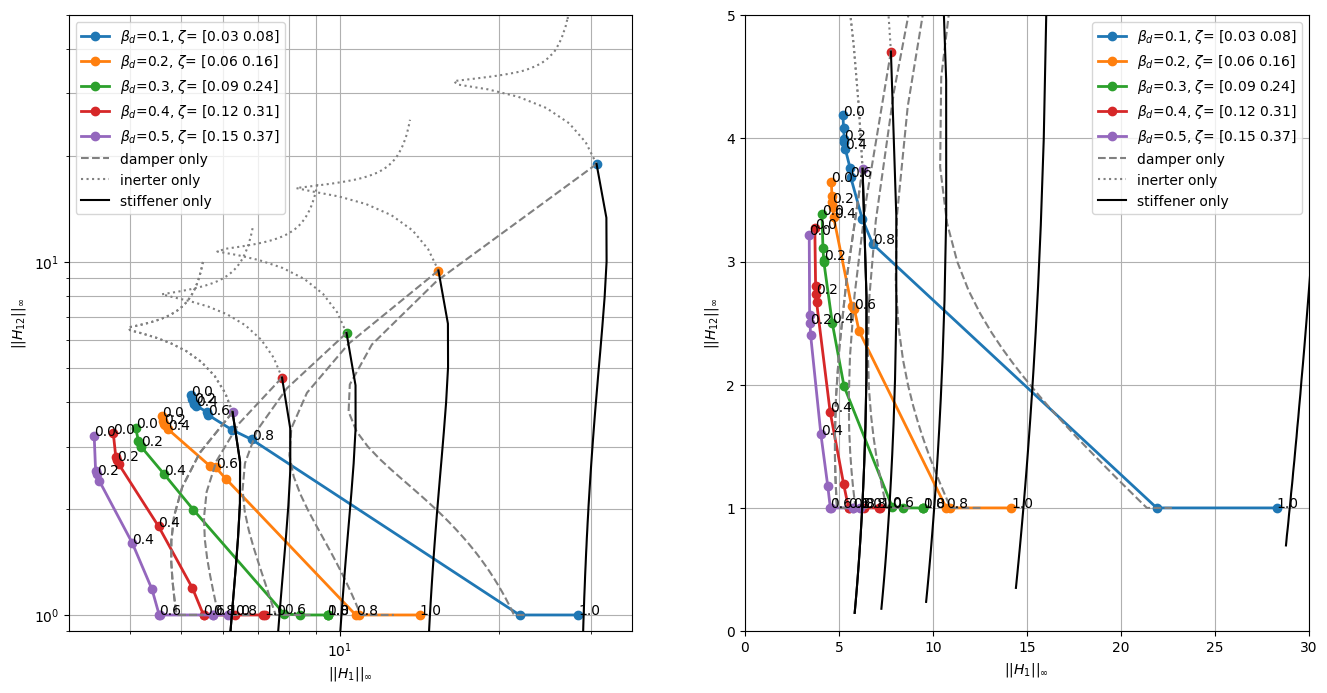

<Figure size 640x480 with 0 Axes>

In [492]:
lambda_step = 2
style.use('default')
fig_pareto, ax = plt.subplots(1, 2, figsize=[16, 8])
for alpha in list(pareto_front_p.keys())[0:5]:
  tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
  ax[0].scatter(x=tf.H_inf(i_output=0), y=tf.H_inf(i_output=1))
  pareto_front = pareto_front_p[alpha]
  w = tf.natural_w(par.get_parameters(alpha, 0, 0))
  ax[0].plot(pareto_front[:,0], pareto_front[:,1], 
             label=r"$\beta_d$" + f"={np.round(alpha, 1)}, " + 
             r'$\zeta$' + f"= {np.round(w*alpha/2,2)}",
             linewidth=2, marker='o')
  ax[0].set_xlabel('$||H_1||_{\infty}$')
  ax[0].set_ylabel('$||H_{12}||_{\infty}$')
  for i_point, point in enumerate(pareto_front[0::lambda_step]):
    ax[0].text(x=point[0], y=point[1], s=np.round(lambda_opt_p[0::lambda_step][i_point],1))
  # benchmarks
  ax[0].plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
             color='grey', linestyle='--',
             label='_nolegend_')
  ax[0].plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
             color='grey', linestyle=':',
             label='_nolegend_')
  ax[0].plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
             color='black', linestyle='-',
             label='_nolegend_')  
ax[0].plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
            color='grey', linestyle='--',
            label='damper only')
ax[0].plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
            color='grey', linestyle=':',
            label='inerter only')
ax[0].plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
            color='black', linestyle='-',
            label='stiffener only') 
ax[0].set_ylim((.9,50))
ax[0].loglog()
ax[0].grid(visible=True, which='both', axis='both')
ax[0].legend()

for alpha in list(pareto_front_p.keys())[0:5]:
  tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
  ax[1].scatter(x=tf.H_inf(i_output=0), y=tf.H_inf(i_output=1))
  pareto_front = pareto_front_p[alpha]
  w = tf.natural_w(par.get_parameters(alpha, 0, 0))
  ax[1].plot(pareto_front[:,0], pareto_front[:,1], 
             label=r"$\beta_d$" + f"={np.round(alpha, 1)}, " + 
             r'$\zeta$' + f"= {np.round(w*alpha/2,2)}",
             linewidth=2, marker='o')
  ax[1].set_xlabel('$||H_1||_{\infty}$')
  ax[1].set_ylabel('$||H_{12}||_{\infty}$')
  for i_point, point in enumerate(pareto_front[0::lambda_step]):
    ax[1].text(x=point[0], y=point[1], s=np.round(lambda_opt_p[0::lambda_step][i_point],1))
  # benchmarks
  ax[1].plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
             color='grey', linestyle='--',
             label='_nolegend_')
  ax[1].plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
             color='grey', linestyle=':',
             label='_nolegend_')
  ax[1].plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
             color='black', linestyle='-',
             label='_nolegend_')  
ax[1].plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
            color='grey', linestyle='--',
            label='damper only')
ax[1].plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
            color='grey', linestyle=':',
            label='inerter only')
ax[1].plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
            color='black', linestyle='-',
            label='stiffener only') 
ax[1].legend(loc='upper right')
ax[1].set_xlim((0,30))
ax[1].set_ylim((0,5))
ax[1].grid(visible=True, which='both', axis='both')

plt.show()
plt.savefig(os.path.join(path,'pareto.pdf'), bbox_inches='tight')

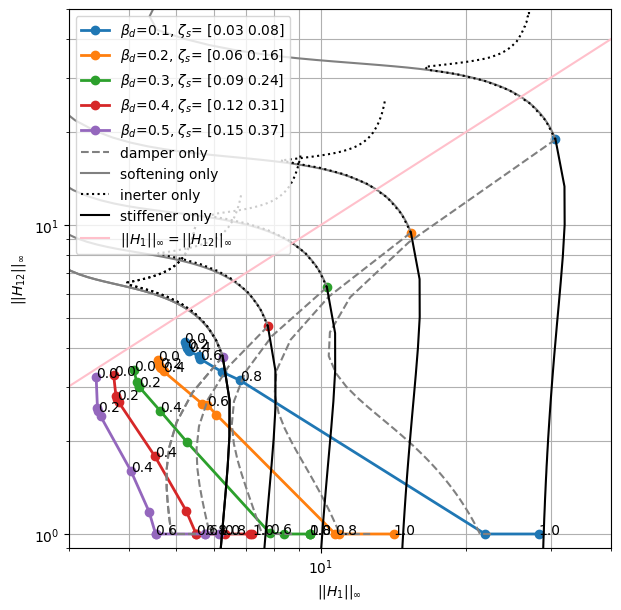

In [493]:
lambda_step = 2
identity = {'x': range(100), 'y': range(100)}
xlims = (3, 40)
ylims = (0.9, 50)
fig_pareto, ax = plt.subplots(1, 1, figsize=[7, 7])
ax.minorticks_on()

for alpha in list(pareto_front_p.keys())[0:5]:
  tf = TF(A, B, C, D).subs(i_output, par.get_parameters(alpha, 0, 0))
  ax.scatter(x=tf.H_inf(i_output=0), y=tf.H_inf(i_output=1))
  pareto_front = pareto_front_p[alpha]
  w = tf.natural_w(par.get_parameters(alpha, 0, 0))
  ax.plot(pareto_front[:,0], pareto_front[:,1], 
             label=r"$\beta_d$" + f"={np.round(alpha, 3)}, " + 
             r'$\zeta_s$' + f"= {np.round(w*alpha/2,2)}", linewidth=2,
             marker='o')
  ax.set_xlabel('$||H_1||_{\infty}$')
  ax.set_ylabel('$||H_{12}||_{\infty}$')
  for i_point, point in enumerate(pareto_front[0::lambda_step]):
    ax.text(x=point[0], y=point[1], s=np.round(lambda_opt_p[0::lambda_step][i_point],10))
  # benchmarks
  ax.plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
             color='grey', linestyle='--',
             label='_nolegend_')
  ax.plot(benchmark_softening_p[alpha][:,0], benchmark_softening_p[alpha][:,1], 
             color='grey', linestyle='-',
             label='_nolegend_') 
  ax.plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
             color='black', linestyle=':',
             label='_nolegend_')
  ax.plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
             color='black', linestyle='-',
             label='_nolegend_')  

ax.plot(benchmark_damper_p[alpha][:,0], benchmark_damper_p[alpha][:,1], 
            color='grey', linestyle='--',
            label='damper only')
ax.plot(benchmark_softening_p[alpha][:,0], benchmark_softening_p[alpha][:,1], 
           color='grey', linestyle='-',
           label='softening only') 
ax.plot(benchmark_inerter_p[alpha][:,0], benchmark_inerter_p[alpha][:,1], 
            color='black', linestyle=':',
            label='inerter only')
ax.plot(benchmark_stiffener_p[alpha][:,0], benchmark_stiffener_p[alpha][:,1], 
            color='black', linestyle='-',
            label='stiffener only') 

ax.plot(identity['x'], identity['y'], color='pink', 
        label=r'$||H_1||_\infty = ||H_{12}||_\infty$')

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.loglog()
ax.grid(visible=True, which='both', axis='both')
ax.legend(loc='upper left')

plt.savefig(os.path.join(path,'pareto_theoric.pdf'), bbox_inches='tight')
plt.show()